In [623]:
import numpy as np
from numpy.linalg import norm,inv,slogdet,matrix_rank
from numpy import array,trace,diag,zeros,ones,full,einsum,sqrt,eye
from copy import deepcopy

from scipy.optimize import minimize
from scipy.stats import multivariate_normal,chi2
from scipy.special import expit

import itertools
import copy
from joblib import Parallel, delayed
from tqdm import tqdm_notebook
from collections import deque

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle,Circle,Ellipse
import imageio

import sys
import os
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from time import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical, Normal, MultivariateNormal
from time import time

from sensors.range_sensor_utils import *
from sensors.range_sensor_3d_utils import *
from sensors.doppler_sensor_3d_utils import *
from sensors.ensembled_sensor_3d_utils import *

from sensors.ensembled_sensor_3d_utils_all import EnsembledSensor3DTorchUtils_2,EnsembledSensors3D_2
from sensors.doppler_sensor_3d_utils_all import *
from sensors.range_sensor_3d_utils_all import *


from trajectory_utils import trajectory_generator_2D,trajectory_sin_2D,trajectory_spiral_3D

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Times New Roman",
    "font.monospace": 'Computer Modern Typewriter'
})

In [6]:
xs,ys,a = trajectory_sin_2D(np.array([0,0]),100,1)
xs,ys,zs, a = trajectory_spiral_3D(np.array([0,0,0]),100,1)

In [324]:
xs,ys,zs,us = trajactory_Tangential_3D(np.array([10,0,0]),100,10,np.pi/2)

In [7]:
#setting constant
range_u_s = [-0.15,0.15]
range_u_t = [-0.001,0.001]

#default is range sensor
sensor_helper = RangeSensorTorchUtils()
sensor_simulator = RangingSensors(zeros((4,3)))

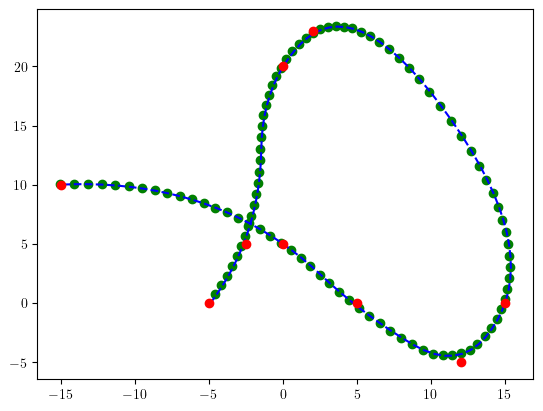

In [8]:
points = np.array([[-5,0],[-2.5,5],[0,20],[2,23],[15,0],[12,-5],[5,0],[0,5],[-15,10]])
xs,ys,a = trajectory_generator_2D(points,101,0)

p = points[0]
vx = 0
vy = 0
for i in range(100):
    px = p[0] + vx + 0.5*a[i,0]
    py = p[1] + vy + 0.5*a[i,1]
    vx = vx + a[i,0]
    vy = vy + a[i,1]
    p =[px,py]
    plt.plot(px,py,'go')

plt.plot(xs,ys,'b--')
plt.plot(points[:,0],points[:,1],'ro')

# Setting I: Range-based 2D sensor
### Stats of observations $y$, for cost function, including
$$\mu(x),C(x),C(x)\prime,\mu(x)\prime,C(x)^{-1}$$

* $x$ is a random variable which denotes target location.  
* $\textbf{xs}$ denotes sensor location. 
* $\textbf{y}$ denotes observation, which depends on both sensors' location and taget location, $\textbf{y} \sim N(\mu(x),C(x))$

* M sensors and each gives one observation, 1-dimensional range observation, N-dimensional space

$$i \in (1,\dots,num\_target)$$
$$j \in (1,\dots,num\_dim)$$
$$k \in (1,\dots,num\_sensor)$$

* 2D transition case:
    * $$\mu(\mathbf{\theta})_i = ||\mathbf{\theta}-s_i||_2$$ 
    * $$[\frac{\partial{\mu(\mathbf{\theta})}}{\partial{\theta}_j}]_{i} = \frac{\theta_j-s_{ij}}{||\mathbf{\theta}-s_i||_2}$$
    * $$ C(\mathbf{\theta})_{ii} = \sigma^2(1+\alpha\mu(\mathbf\theta)_i^2)$$
    * $$[\frac{\partial{C(\mathbf{\theta})}}{\partial{\theta}_j}]_{ii} = 2\alpha\sigma^2 (\theta_{j}-s_{ij})$$
    
    * 4D transition case 1:
    * $$\mu(\mathbf{\theta})_i = ||e^\top\mathbf{\theta}-e^\top s_i||_2$$ 
    * $$[\frac{\partial{\mu(\mathbf{\theta})}}{\partial{\theta}_j}]_{i} = \frac{ee^\top\theta_j-ee^\top s_{ij}}{||e^\top\mathbf{\theta}-e^\top s_i||_2}$$
    * $$ C(\mathbf{\theta})_{ii} = \sigma^2(1+\alpha\mu(\mathbf\theta)_i^2)$$
    * $$[\frac{\partial{C(\mathbf{\theta})}}{\partial{\theta}_j}]_{ii} = 2\alpha\sigma^2 (ee^\top\theta_{j}-ee^\top s_{ij})$$
    
    * 4D transition case 2:
    * $$\mu(\mathbf{\theta})_i = ||e^\top A\mathbf{\theta}-e^\top s_i||_2$$ 
    * $$[\frac{\partial{\mu(\mathbf{\theta})}}{\partial{\theta}_j}]_{i} = \frac{A^\top ee^\top (A\theta_j-s_{ij})}{||e^\top A\mathbf{\theta}-e^\top s_i||_2}$$
    * $$ C(\mathbf{\theta})_{ii} = \sigma^2(1+\alpha\mu(\mathbf\theta)_i^2)$$
    * $$[\frac{\partial{C(\mathbf{\theta})}}{\partial{\theta}_j}]_{ii} = 2\alpha\sigma^2 (A^\top ee^\top(A\theta_{j}-s_{ij}))$$


## Maximum-Likelihood Estimator & Fisher Infomation & Cramer Rao Lower Bound

* MLE

$$ f(X;\theta) = (2\pi)^{-\frac{M}{2}}|Cov(\theta)|^{-\frac{1}{2}}\exp\{-\frac{1}{2}(X-\mu(\theta))^\top Cov(\theta)^{-1}(X-\mu(\theta))\}$$
$$l = \log{f(X;\theta)} = C - \frac{1}{2}log |Cov(\theta)| -\frac{1}{2}(X-\mu(\theta))^\top Cov(\theta)^{-1}(X-\mu(\theta))$$

* Fisher Information, $\textrm{I}(\mathbf{\theta}): (M\times M)$

$${\mathcal {I}}(\theta )=\operatorname {E} \left[\left.\left({\frac {\partial }{\partial \theta }}\log f(X;\theta )\right)^{2}\right|\theta \right]=\int _{\mathbb {R} }\left({\frac {\partial }{\partial \theta }}\log f(x;\theta )\right)^{2}f(x;\theta )\,dx$$

$$[\textrm{I}(\mathbf{\theta})_{ik}] = (\frac{\partial{\mu(\mathbf{\theta})}}{\partial{\theta_i}})^\top C^{-1}(\mathbf{\theta})(\frac{\partial{\mu(\mathbf{\theta})}}{\partial{\theta_k}}) + \frac{1}{2}\textrm{tr}\{C^{-1}(\mathbf{\theta})\frac{\partial{C{(\mathbf{\theta})}}}{\partial{\theta_i}}C^{-1}(\mathbf{\theta})\frac{\partial{C{(\mathbf{\theta})}}}{\partial{\theta_k}}\}$$

* CRLB
$$CRLB = \mathcal{I(\theta)}^{-1}$$

In [703]:
def observe(mu,cov): 
    n_targets = mu.shape[0]
    obs = zeros(mu.shape)
    for i in range(n_targets):
        obs[i] = multivariate_normal.rvs(mean=mu[i], cov=cov[i])
    return obs

def neglog_gaussian(obs,mu,cov):
    muo = obs-mu
    n_targets = mu.shape[0]
    ll = 0
    for i in range(n_targets):
        inv_cov = inv(cov[i])
        ll += muo[i,:].T@inv_cov@muo[i,:] + slogdet(cov[i])[1]
    return ll

def fun_mle_gaussian_1(*params):
    x,obs,sim = params
    n_targets = obs.shape[0]
    dim = int(len(x)/n_targets)
    x = array(x).reshape((dim,n_targets))
    mu = sim.hx(x)
    cov = sim.sx(x)
    ll = neglog_gaussian(obs,mu,cov)
    return ll

def fisher_information(mu,cov,d_mu,d_cov):
    n_targets,dim,n_sensors = d_mu.shape
    I = zeros((n_targets,dim,dim))
    for k in range(n_targets):
        inv_cov = inv(cov[k])
        for i in range(dim):
            for j in range(dim):
                I[k,i,j] = d_mu[k,i,:]@inv_cov@d_mu[k,j,:].T + 0.5*np.trace(inv_cov@d_cov[k,i,:,:]@inv_cov@d_cov[k,j,:,:])
    return I

def crlb(*args):
    f = fisher_information(*args)
    n_targets,dim,dim = f.shape
    J = 0
    for i in range(n_targets):
        fr = matrix_rank(f[i])
        if fr == dim: 
            lb = inv(f[i])
            J += trace(lb)
        else:
            J += np.inf
        
    return J

def crlb_rmse(*args):
    f = fisher_information(*args)
    n_targets,dim,dim = f.shape
    rmse_p = np.zeros(n_targets)
    rmse_v = np.zeros(n_targets)
    for i in range(n_targets):
        fr = matrix_rank(f[i])
        if fr == dim:
            lb = inv(f[i])
            if isinstance(sensor_helper,EnsembledSensor3DTorchUtils) or isinstance(sensor_helper,EnsembledSensor3DTorchUtils_2):
                rmse_p[i] = np.sqrt(trace(lb[:dim//2,:dim//2]))
                rmse_v[i] = np.sqrt(trace(lb[dim//2:,dim//2:]))
            else:
                rmse_p[i] = np.sqrt(trace(lb))
        else:
            rmse_p[i] = np.inf
            rmse_v[i] = np.inf
    return rmse_p,rmse_v
    
def error_cov(*args):
    f = fisher_information(*args)
    n_targets,dim,dim = f.shape
    C_sqt = zeros((n_targets,dim,dim))
    for i in range(n_targets):
        fr = matrix_rank(f[i])
        if fr == dim: 
            try:
                C_sqt[i,:,:] = np.linalg.cholesky(inv(f[i])).T
            except:
                C_sqt[i,:,:] = 1000*eye(dim)  
        else:
            C_sqt[i,:,:] = 1000*eye(dim)   
    return C_sqt


def estimate_mle(rs,obs,initial_guess):
    x_shape = initial_guess.shape
    res = minimize(fun_mle_gaussian_1,x0=initial_guess.flatten(),args=(obs,rs),method='L-BFGS-B',options={'gtol':1e-8,'ftol':1e-16,'maxiter':2000})
    #print(res)
    est = res.x.reshape(x_shape)
    
    #variance bound of estimator
    C_sqt = error_cov(rs.hx(est),rs.sx(est),rs.H(est),rs.S(est))
    
    dim,n_target = x_shape
    
    if C_sqt.shape[1]<dim:
        C_ = np.zeros((n_target,dim,dim))
        for i in range(n_target):
            C_[i,:,:] = np.eye(dim)
            C_[i,:C_sqt.shape[1],:C_sqt.shape[1]] = C_sqt[i,:,:]
    
        C_sqt = C_
  
    return est,C_sqt,res.success

In [704]:
targets = np.array([[0.,10,0,0,1,0],[0,-2,0,-1,-1,0.4]]).T
sensors = np.array([[0.01,0,2,0,0,0],[0,3,0,0,1,0],[0.,10,0,0,0,0]]).T
initial_guess = np.zeros((6,2))
rs = RangingSensors3D(sensors)
obs = observe(rs.hx(targets),rs.sx(targets))

In [705]:
estimate_mle(rs,obs,initial_guess)

(array([[ 1.16505681e-04,  2.57332137e-03],
        [ 9.80405119e+00, -1.80909590e+00],
        [ 2.33182243e-02,  5.14557491e-01],
        [ 0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00]]),
 array([[[ 1.39366756e+06, -1.46005224e-01, -6.96788354e+03,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  4.63770929e-01,  2.69020003e+00,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  2.17109075e+00,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           0.00000000e+00,  0.00000000e+00,  1.00000000e+0

In [706]:
targets = np.array([[3.,1,2,0,-1,5]]).T
sensors = np.array([[0,0,-2,-1,0,0],[2,3,-2,0,0,0]]).T

ds = DopplerSensors3D(sensors)
FIM = fisher_information(ds.hx(targets),ds.sx(targets),ds.H(targets),ds.S(targets))
FIM

array([[[ 0.08422585,  0.03209393, -0.07991973, -0.1336615 ,
          0.02386474, -0.25640799],
        [ 0.03209393,  0.11062513, -0.04260319, -0.09455202,
         -0.10304585, -0.04432249],
        [-0.07991973, -0.04260319,  0.07733408,  0.13221431,
         -0.00879746,  0.23670735],
        [-0.1336615 , -0.09455202,  0.13221431,  0.23145096,
          0.01184168,  0.38323972],
        [ 0.02386474, -0.10304585, -0.00879746,  0.01184168,
          0.13456451, -0.13348799],
        [-0.25640799, -0.04432249,  0.23670735,  0.38323972,
         -0.13348799,  0.80954009]]])

In [707]:
u = ((sensors-targets)/np.linalg.norm(sensors-targets,axis=0))

(u[:,[0]]@u[:,[0]].T + u[:,[1]]@u[:,[1]].T)/2.3

array([[ 0.0830817 ,  0.00610895,  0.13544412,  0.02461034, -0.03386103,
         0.16930515],
       [ 0.00610895,  0.04520622, -0.04119177,  0.00820345,  0.01029794,
        -0.05148971],
       [ 0.13544412, -0.04119177,  0.27926623,  0.03281378, -0.06981656,
         0.34908278],
       [ 0.02461034,  0.00820345,  0.03281378,  0.00820345, -0.00820345,
         0.04101723],
       [-0.03386103,  0.01029794, -0.06981656, -0.00820345,  0.01745414,
        -0.0872707 ],
       [ 0.16930515, -0.05148971,  0.34908278,  0.04101723, -0.0872707 ,
         0.43635348]])

In [18]:
targets = np.array([[3.,1,2,0,-1,5],[2,5,3,0,10,0]]).T
sensors = np.array([[0,0,-2,-1,0,0],[2,3,-2,0,0,0],[10.,-5,-2,0,0,1],[-2.,0,5,0,0,1]]).T

rs = RangingSensors3D(sensors)

obs = observe(rs.hx(targets),rs.sx(targets))
estimate_mle(rs,obs,np.zeros((6,2)))             

(array([[3.11858382, 1.60438251],
        [0.55649005, 5.46981024],
        [1.56423554, 2.00309612],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ]]),
 array([[[ 0.41812745,  0.26847118,  0.03984213,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.62463658,  0.06913583,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.38995476,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ,  1.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ,  0.        ,
           1.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ,  0.        ,
           0.        ,  1.        ]],
 
        [[ 0.67564431, -0.11474668,  0.23459933,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.40239497, -0.24460418,  0.        ,
           0.        ,  0.        ],

## System Dynamics

### I: velocity as control
* $\textbf{x}$ denotes state, $\textbf{u}$ denotes control, $\textbf{a}$ denotes adversarial disturbance
 $$\textbf{x}_k = \left(\begin{array}{c}\textbf{x}_k^s\\ 
\textbf{x}_k^t\end{array}\right),\textbf{x}_k^s = [p], \textbf{x}_k^s = \textbf{x}_{k-1}^s + \textbf{u}_k, \textbf{x}_k^t = \textbf{x}_{k-1}^t + \textbf{a}_k$$

### II: acceleration as control
 $$\textbf{x}_k = \left(\begin{array}{c}\textbf{x}_k^s\\ 
\textbf{x}_k^t\end{array}\right),\textbf{x}_k^s = [p,v], \textbf{x}_k^s = \textbf{Ax}_{k-1}^s + \textbf{Bu}_k, \textbf{x}_k^t = \textbf{Ax}_{k-1}^t + \textbf{Ba}_k$$

## Cost function

In [613]:
def fisher_information_torch(mu,cov,d_mu,d_cov):
    n_targets,dim,n_sensors = d_mu.shape
    I = torch.zeros((n_targets,dim,dim))
    for k in range(n_targets):
        inv_cov = torch.linalg.inv(cov[k])
        for i in range(dim):
            for j in range(dim):
                I[k,i,j] = d_mu[k,[i],:]@inv_cov@d_mu[k,[j],:].T + 0.5*torch.trace(inv_cov@d_cov[k,i,:,:]@inv_cov@d_cov[k,j,:,:])
    return I

def with_velocity_tracking():
    global sensor_helper
    return ((isinstance(sensor_helper,EnsembledSensor3DTorchUtils) 
        | isinstance(sensor_helper,DopplerSensor3DTorchUtils) 
        | isinstance(sensor_helper,EnsembledSensor3DTorchUtils_2) 
        | isinstance(sensor_helper,DopplerSensor3DTorchUtils_2)))

def crlb_torch(mu,cov,d_mu,d_cov,kappa = 1):
    f = fisher_information_torch(mu,cov,d_mu,d_cov)
    n_targets,dim,dim = f.shape
    
    W = torch.eye(dim)
    if with_velocity_tracking():
        W[dim//2:,dim//2:] = torch.eye(dim//2)*kappa
    
    J = 0
    for i in range(n_targets):
        try: 
            lb = torch.linalg.inv(f[i])
        except:
            lb = torch.linalg.pinv(f[i])
        
        J += torch.trace(W@lb)
        
    return sensor_helper.rescale(J)

## Auto Grad

In [708]:
def reparam(u,lower,upper): #reparameterize
    return torch.sigmoid(u).mul(upper-lower)+lower
    
def forward(x_s,x_t,u_s,u_t,v,C_sqt,w,alpha=0.95,kappa = 1):
    u_s_shape = u_s.shape
    u_t_shape = u_t.shape
    
    #time horizon K
    K = u_t_shape[0]
    
    #deal with x_0
    if v.requires_grad:
        degree_freedom = u_t_shape[1] - 1
        print('df',degree_freedom)
        q = sqrt(chi2.ppf(alpha,degree_freedom))
        v = reparam(v,-q,q)
        
        v_trans = torch.zeros(v.shape)
        for n_target in range(v.shape[1]):
            v_trans[:,n_target] = C_sqt[n_target,:,:]@v[:,n_target]
        v = v_trans
        
    #reparameterize
    if u_s.requires_grad:
        u_s = reparam(u_s,*range_u_s)
    
    if u_t.requires_grad:
        u_t = reparam(u_t,*range_u_t)
    
    #initialize variables
    L = torch.zeros(K)
    x_s_ = torch.zeros(u_s_shape)
    x_t_ = torch.zeros(u_t_shape)
    
    for k in range(K):
        if k == 0:
            x_s_[k] = sensor_helper.transition(x_s,u_s[k])
            x_t_[k] = sensor_helper.transition_target(x_t+v,u_t[k])
        else:
            x_s_[k] = sensor_helper.transition(x_s_[k-1],u_s[k])
            x_t_[k] = sensor_helper.transition_target(x_t_[k-1],u_t[k])
        
        #step cost
        mu = sensor_helper.hx(x_t_[k],x_s_[k])
        cov = sensor_helper.sx(x_t_[k],x_s_[k])
        d_mu = sensor_helper.H(x_t_[k],x_s_[k])
        d_cov = sensor_helper.S(x_t_[k],x_s_[k])
        L[k] = crlb_torch(mu,cov,d_mu,d_cov,kappa)
    
    return torch.dot(L,w)

def ekf(P,FPF_Q,F,d_mu,cov):
    n_targets,dim,n_sensors = d_mu.shape
    s_dim = F.shape[0]
    
    P_ = torch.zeros(P.shape)
    J = 0
    
    for it in range(n_targets): #for each target
        H = torch.zeros((n_sensors,s_dim))
        H[:,:dim] = d_mu[it].T
        R = cov[it]
        
        FPH_T = F@P[it]@H.T 
        inv_S = torch.linalg.inv(H@P[it]@H.T + R)
        P_[it] = FPF_Q[it] - FPH_T@inv_S@FPH_T.T
        J += torch.trace(P_[it])
    return J,P_

def forward_ekf(x_s,x_t,u_s,u_t,v,C_sqt,w):
    u_s_shape = u_s.shape
    u_t_shape = u_t.shape
    
    #time horizon T
    T = u_t_shape[0]
    #deal with x_0
    if v.requires_grad:
        q = sqrt(chi2.ppf(0.95,2))
        v = reparam(v,-q,q)
        
        v_trans = torch.zeros(v.shape)
        for n_target in range(v.shape[1]):
            v_trans[:,n_target] = C_sqt[n_target,:,:]@v[:,n_target]
        v = v_trans
    
    #reparameterize
    if u_s.requires_grad:
        u_s = reparam(u_s,*range_u_s)
    
    if u_t.requires_grad:
        u_t = reparam(u_t,*range_u_t)
    
    #initialize variables
    L = torch.zeros(T)
    x_s_ = torch.zeros(u_s_shape)
    x_t_ = torch.zeros(u_t_shape)
    
    #P0
    n_targets,dim,dim = C_sqt.shape
    P = torch.zeros(C_sqt.shape)
    for it in range(n_targets):
        P[it] = torch.linalg.inv(C_sqt[it,:,:].T@C_sqt[it,:,:])
    
    for k in range(T):
        if k == 0:
            x_s_[k] = sensor_helper.transition(x_s,u_s[k])
            x_t_[k] = sensor_helper.transition_target(x_t+v,u_t[k])
        else:
            x_s_[k] = sensor_helper.transition(x_s_[k-1],u_s[k])
            x_t_[k] = sensor_helper.transition_target(x_t_[k-1],u_t[k])
            
        d_mu = sensor_helper.H(x_t_[k],x_s_[k])
        d_cov = sensor_helper.S(x_t_[k],x_s_[k])
        cov = sensor_helper.sx(x_t_[k],x_s_[k])
        F = sensor_helper.get_F()
        
        FPF_Q = torch.zeros(P.shape)
     
        for it in range(n_targets):
            FPF_Q[it] =sensor_helper.transition_matrix(P[it],torch.ones(dim)*range_u_s[1],torch.ones(dim)*range_u_s[0])
            
        l,P = ekf(P,FPF_Q,F,d_mu,cov)
        L[k] = l
        
    return torch.dot(L,w)

## Gradient Descent

In [709]:
def train_gradient_descent(optimizer,x_s,x_t,u_s,u_t,v,C_sqt,w,ekf=False,kappa = 1):
    optimizer.zero_grad()
   
    if ekf:
        loss = forward_ekf(x_s,x_t,u_s,u_t,v,C_sqt,w)
    else:    
        loss = forward(x_s,x_t,u_s,u_t,v,C_sqt,w,kappa)
    
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        loss_val = loss.item()
            
    return loss_val

In [710]:
def greedymove(x_s,x_t,lr,C_sqt,is_target=True,maxi = True,n_iter = 600, ekf = False,kappa = 1):
    s_shape = x_s.shape
    t_shape = x_t.shape
    
    T = 1
    
    if is_target:
        u_s = torch.zeros((T,*s_shape))
        u_t = torch.tensor(0.001*np.random.randn(T,*t_shape), requires_grad = True)
    else:
        u_s = torch.tensor(0.001*np.random.randn(T,*s_shape), requires_grad = True)
        u_t = torch.zeros((T,*t_shape))
        
    v = torch.zeros(t_shape)
        
    losses = []
    
    opt = optim.Adam([u_t if is_target else u_s],lr = lr)
    
    if maxi:
        opt.param_groups[0]['lr'] *= -1 #change descending to ascending
    
    for i in range (n_iter):
        loss_val = train_gradient_descent(opt,x_s,x_t,u_s,u_t,v,C_sqt,torch.ones(T),ekf=ekf,kappa = kappa)
        losses.append(loss_val)
        #print(loss_val)
        if loss_val==np.inf:
            break
            
    
    if is_target:
        u = reparam(u_t.detach(),*range_u_t)
    else:
        u = reparam(u_s.detach(),*range_u_s)
        
    return u,losses

In [711]:
#Settings

range_u_s = [-0.15,0.15]
range_u_t = [-0.1,0.1]

sensor_helper = RangeSensorTorchUtils()
sensor_simulator = RangingSensors(zeros((4,3)))

lr_t = 0.01
xs = np.array([[-2.9414, -1.3868,-1,1], [-2.5536, -0.6925,0,1],[-1.4836,  0.4326,0.5,0.5]]).T
xt = np.array([[-1.9170, -0.9756, 1,1]]).T

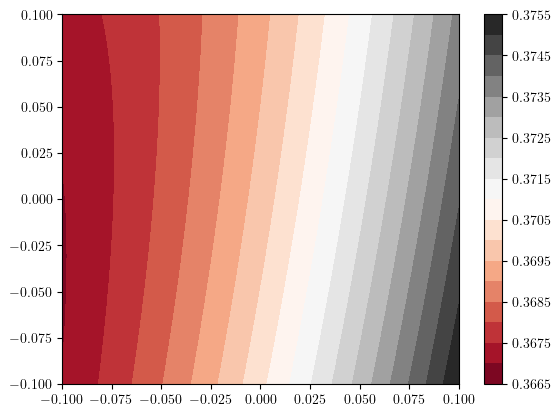

In [712]:
X,Y = np.mgrid[-0.1:0.105:0.005, -0.1:0.105:0.005]
N,M = X.shape
Z = np.zeros((N,M))
rs = RangingSensors(xs)
for i in range(N):
    for j in range(M):
        u = np.array([[0,0,X[i,j],Y[i,j]]]).T
        xs_ = RangingSensors.transition(xs,zeros(xs.shape))
        xt_ = RangingSensors.transition_target(xt,u)
        rs.states = xs_
        Z[i,j] = crlb(rs.hx(xt_),rs.sx(xt_),rs.H(xt_)[:,:2],rs.S(xt_)[:2,:,:])
            
plt.contourf(X, Y, Z, 20, cmap='RdGy')
plt.colorbar()
plt.show()

In [713]:
u_t,losses = greedymove(torch.tensor(xs),torch.tensor(xt),lr_t,torch.zeros((1,4,4)),is_target=True,maxi=True)
u_t

tensor([[[-4.7325e-05],
         [ 9.9685e-06],
         [ 9.4902e-02],
         [-9.5483e-02]]])

In [714]:
u_t,losses = greedymove(torch.tensor(xs),torch.tensor(xt),lr_t,torch.zeros((1,2,2)),is_target=True,maxi=False)
u_t

tensor([[[ 5.4511e-06],
         [ 5.6958e-05],
         [-9.0727e-02],
         [-9.0410e-03]]])

In [196]:
u_s,losses = greedymove(torch.tensor(xs),torch.tensor(xt),lr_t,torch.zeros((1,4,4)),is_target=False,maxi=False)
u_s

tensor([[[-6.6094e-08,  8.1445e-05,  1.0440e-05],
         [ 6.6170e-05, -1.4124e-05,  4.7981e-05],
         [ 1.4039e-01,  1.4438e-01,  1.3233e-01],
         [-1.3944e-01,  1.4361e-01,  9.4590e-02]]])

## Gradient Descent Ascent

In [715]:
def train_gradient_descent_ascent(opts,x_s,x_t,u_s,u_t,v,C_sqt,w,ekf=False,kappa = 1):
    for opt in opts:
        opt.zero_grad()
   
    if ekf:
        loss = forward_ekf(x_s,x_t,u_s,u_t,v,C_sqt,w)
    else:
        loss = forward(x_s,x_t,u_s,u_t,v,C_sqt,w,kappa)
    
    loss.backward()
    
    for opt in opts:
        opt.step()
    
    with torch.no_grad():
        loss_val = loss.item()
            
    return loss_val

def robustmove(T,x_s,x_t,lr_s,lr_t,C_sqt,w,n_iter = 800,ekf=False,kappa = 1):
    s_shape = x_s.shape
    t_shape = x_t.shape
   
    u_s = torch.tensor(0.01*np.random.randn(T,*s_shape), requires_grad=True)
    u_t = torch.tensor(0.01*np.random.randn(T,*t_shape), requires_grad=True)
    #uncertainty variable
    v = torch.zeros(t_shape,requires_grad=True)
    losses = []
    
    opt_t = optim.Adam([u_t,v],lr = lr_t) 
    opt_t.param_groups[0]['lr'] *= -1
    
    opt_s = optim.Adam([u_s],lr = lr_s)
    
    for i in range (n_iter):
        loss_val = train_gradient_descent_ascent([opt_s,opt_t],x_s,x_t,u_s,u_t,v,C_sqt,w,ekf=ekf,kappa=kappa)
        losses.append(loss_val)
        
    u_s_val = reparam(u_s.detach(),*range_u_s)
    
    return u_s_val,losses


def move(T,x_s,x_t,lr_s,C_sqt,w,n_iter = 800,ekf=False,kappa=1):
    s_shape = x_s.shape
    t_shape = x_t.shape
   
    u_s = torch.tensor(0.01*np.random.randn(T,*s_shape), requires_grad=True)
    u_t = torch.zeros((T,*t_shape))
    v = torch.zeros(t_shape)
    losses = []
    
    opt_s = optim.Adam([u_s],lr = lr_s)
    
    for i in range (n_iter):
        loss_val = train_gradient_descent(opt_s,x_s,x_t,u_s,u_t,v,C_sqt,w,ekf=ekf,kappa=kappa)
        losses.append(loss_val)
        
    u_s_val = reparam(u_s.detach(),*range_u_s)
    
    return u_s_val,losses

def sample_actions(a_shape,range_v):
    
    #upper and lower bound of sample
    
    range_v_l,range_v_u = range_v
    N,M = a_shape
    sample_size = (3**N)**M
    if not hasattr(range_v_l ,'len'):
        range_v_l = np.full(N,range_v_l)
        
    if not hasattr(range_v_l ,'len'):
        range_v_u = np.full(N,range_v_u)
    
    samples = np.zeros((sample_size,*a_shape))
    
    v = np.zeros((N,3))
    for i in range(N):
        v[i] = [range_v_l[i],0,range_v_u[i]]#lowerbound, zero, upperbound
    
    
    sactions = [[v[j][p[j]] for j in range(N)] for p in itertools.product(*(range(3) for i in range(N)))]
    
    sactions = np.array(sactions)
   
    
    samples = [[sactions[p[j]] for j in range(M)] for p in itertools.product(*(range(9) for i in range(M)))] 
    samples = np.array(samples)
    
    return np.swapaxes(samples,1,2)

def robustmove_samp(x_s,x_t,lr_t):
    s_shape = x_s.shape
    t_shape = x_t.shape
    
    min_loss = np.inf
    
    u_s_samples = sample_actions((2,s_shape[1]),range_u_s)
    u_s_samples = torch.tensor(u_s_samples)
    n_samples = u_s_samples.shape[0]
    u_s_samples = torch.cat([torch.zeros((n_samples,2,s_shape[1])),u_s_samples],dim=1)
    
    for i in range(n_samples):
        #sample a action from the space
        u_s = u_s_samples[i]
        
        #perform counter move
        u_t,u_loss = greedymove(sensor_helper.transition(x_s,u_s),x_t,lr_t,torch.zeros((1,x_t.shape[0],x_t.shape[0])),is_target=True,maxi=True)
        
            
        if u_loss[-1]<min_loss:
            min_loss = u_loss[-1]
            u_s_ = u_s
    
    return u_s_

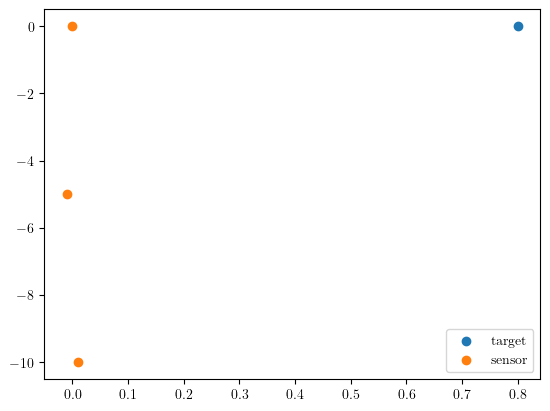

In [716]:
#Settings
range_u_s = [-0.015,0.015]
range_u_t = [-0.01,0.01]
lr_t = 0.01
lr_s = 0.03
xs = torch.tensor(np.array([[0.,0.,0.,0.],
        [-0.01, -5, 0, 0],
        [0.01,  -10,0, 0]])).T
xt = torch.tensor(np.array([[ 0.8,0,0,0]])).T

plt.scatter(xt[0,:],xt[1,:],label='target')
plt.scatter(xs[0,:],xs[1,:],label='sensor')
plt.legend()

In [ ]:
u_s1 = robustmove_samp(xs,xt,lr_t)

In [ ]:
u_s1

In [ ]:
u_s2,_ = robustmove(1,xs,xt,lr_s,lr_t,torch.zeros((1,4,4)),torch.ones(1))

In [ ]:
u_s2

In [36]:
p = torch.zeros((1,4,4))
p[0] = torch.tensor(np.linalg.cholesky(np.eye(4)).T)
u_s2,_ = robustmove(1,xs,xt,lr_s,lr_t,p,torch.ones(1))

In [37]:
u_s2

tensor([[[ 9.0946e-05, -5.2999e-05,  7.0933e-06],
         [-4.9048e-05, -5.2832e-05, -1.9337e-05],
         [-9.9056e-03,  8.5906e-03,  1.0569e-02],
         [ 1.4340e-02, -1.4407e-02, -9.7626e-03]]])

In [38]:
u_s2,_ = move(1,xs,xt,lr_s,torch.zeros((1,4,4)),torch.ones(1))

In [39]:
u_s2[0]

tensor([[ 2.9842e-05, -6.8120e-05,  3.8431e-05],
        [-1.0097e-04,  6.0367e-05,  1.2987e-05],
        [ 1.4955e-02,  1.4884e-02,  1.4888e-02],
        [ 1.4888e-02, -1.4881e-02, -1.4886e-02]])

## Simulation and Evaluation

In [507]:
def plotframe(T,frame,costs,rect,n_range_sensors):
    fig = plt.figure(figsize=(12,6))
    
    ax = plt.subplot(1,2,1)

    ax.add_patch(Circle((frame['target'][0,0],frame['target'][1,0]), 3, color='blue',label='target'))
    
    
    ax.add_patch(Circle((frame['est'][0,0], frame['est'][1,0]), 4, alpha=0.1, color='red',label='estimated target'))
    #TO-DO
    #ax.add_patch(Ellipse((frame['est'][0,0], frame['est'][1,0]), width=2*frame['uncertainty'][0]*(10**8)*1.5, height=2*frame['uncertainty'][1]*(10**8)*1.5, alpha=0.4, color='green'))
    
    sensors = frame['sensor']
    obs = frame['obs']
    
    for i in range(n_range_sensors):
        c = (sensors[0,i], sensors[1,i])
        r = obs[0,i]
        ax.add_patch(Circle(c, 3, color='orange'))
        #ax.add_patch(Circle(c, r, color='orange',alpha=0.1))
    
    for i in range(sensors.shape[1]-n_range_sensors):
        c = (sensors[0,i+n_range_sensors], sensors[1,i+n_range_sensors])
        ax.add_patch(Circle(c, 3, color='green'))
    
    plt.title(f'T={frame["k"]}/{T}ß')
    plt.ylim(rect[2],rect[3])
    plt.xlim(rect[0],rect[1])
    plt.legend()
    
    ax1 = plt.subplot(1,2,2)
    ax1.plot(range(1,frame['k']+1),costs[:frame['k']],label='estimation error',c='orange')
    ax1.set_ylim(min(costs),max(costs))
    ax1.set_ylabel('absolute estimation error')
    ax1.legend(loc='center left')
    ax1.set_yscale('log')
    
    plt.xlim(1,len(costs)+1)
    plt.title('Time-Cost')
    plt.xlabel('T')
    
    plt.savefig(f'./img/img_{frame["k"]}.png', 
                    transparent = False,  
                    facecolor = 'white'
                   )
    fig.clf()
    plt.close(fig)
    
def plotgif(T,frames,costs,rect,prefix,n_range_sensors):
    gif_imgs = []
    for frame in frames:
        plotframe(T,frame,costs,rect,n_range_sensors)
        gif_imgs.append(imageio.v2.imread(f'./img/img_{frame["k"]}.png'))
    
    imageio.mimsave(f'./{prefix}_T={T}.gif',gif_imgs,fps = 4)  
    
def extract_costs(frames,with_velocity=False):
    costs = []
    sensor_trac = []
    target_trac = []
    est_trac = []
    velocity_err = []
    crb_rmse_p = []
    crb_rmse_v = []
    for frame in frames:
        costs.append(frame['abs_err'])
        sensor_trac.append(frame['sensor'])
        target_trac.append(frame['target'])
        est_trac.append(frame['est'])
        crb_rmse_p.append(frame['crb_rmse_p'])
        crb_rmse_v.append(frame['crb_rmse_v'])
        if with_velocity:
            dim = frame['target'].shape[0]//2
            ve = np.linalg.norm(frame['target'][dim:]-frame['est'][dim:],axis=0)
            velocity_err.append(ve)
    if with_velocity:
        return costs,array(sensor_trac),array(target_trac),array(est_trac),array(velocity_err),array(crb_rmse_p),array(crb_rmse_v)
    return costs,array(sensor_trac),array(target_trac),array(est_trac),array(crb_rmse_p)

In [19]:
def find_symmetric(sensors,target):
    idx_sensor = np.argmin(((sensors-target)**2).sum(axis=0))
    symmetric_point = 2*sensors[:,[idx_sensor]]-target
    return symmetric_point

In [20]:
def moving_average(a, n=10) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [21]:
def smooth_trajectory(K):
    x_t = torch.zeros((4,1))
    x_t[2,:] = 0
    x_t[3,:] = 0.25
    
    x_s = torch.zeros((4,3))
    
    x_s[0,0] = 0.01
    x_s[0,1] = 0
    x_s[0,2] = -0.01
    x_s[1,0] = -5
    x_s[1,1] = -10
    x_s[1,2] = -15
    
    previous_est = torch.zeros(x_t.shape)
    u_t =  torch.zeros((4,K))
    u_t[2,int(K/4):] = 0.005
    u_t[3,int(K/4):] = -0.01
    return x_t,x_s,u_t

def trajectory2D_2(K):
    points =  np.array([[-5,0],[-2.5,5],[0,20],[2,23],[15,0],[12,-5],[5,0],[0,5],[-15,10]])
    _,_,a = trajectory_generator_2D(points,K+1,0)
    
    x_t = torch.zeros((4,1))
    x_t[0,:] = -5
    x_t[1,:] = 0
    
    x_s = torch.zeros((4,3))
    
    x_s[0,0] = -5.01
    x_s[0,1] = -5
    x_s[0,2] = -4.99
    x_s[1,0] = -5
    x_s[1,1] = -10
    x_s[1,2] = -15
    
    u_t = torch.zeros((4,K))
    u_t[2,:] = torch.tensor(a[:,0])
    u_t[3,:] = torch.tensor(a[:,1])
    return x_t,x_s,u_t

In [614]:
def tracking_smooth(K,T,lr_s,lr_t,w,trajectory,previous_est,robust=True,ekf=False):
    frames = []
    
    x_t,x_s,u_t = trajectory(K)
   
    x_t_n = x_t.numpy()
    x_s_n = x_s.numpy()
    sensor_simulator.states = x_s_n
    
    for k in range(K):
        frame = {}
        
        x_t_n = x_t.numpy()
        x_s_n = x_s.numpy()
        
        frame['target'] = x_t_n
        frame['sensor'] = x_s_n
        
        #STEP 1. read observaion
        t_a = time()
        obs = observe(sensor_simulator.hx(x_t_n),sensor_simulator.sx(x_t_n))
        frame['obs'] = obs
        
        #STEP 2. estimate target
        est,C_sqt = estimate_mle(sensor_simulator,obs,previous_est)
        ll = neglog_gaussian(obs,sensor_simulator.hx(est),sensor_simulator.sx(est))
        #print(est,err)
        if isinstance(sensor_simulator,RangingSensors):
            another_guess = find_symmetric(x_s_n,est)
            est2,C_sqt2 = estimate_mle(sensor_simulator,obs,another_guess)
            ll2 = neglog_gaussian(obs,sensor_simulator.hx(est2),sensor_simulator.sx(est2))

            if ll2<ll:
                est = est2
                C_sqt = C_sqt2
            
            velocity = sensor_helper.estimate_velocity(est,previous_est) 
            est[2:,:] = velocity
            
        frame['est'] = est
        frame['abs_err'] = sensor_helper.abs_err(x_t_n,est)
        
        x_s_n_prev = x_s_n.copy()
        previous_est = est.copy()
        #print(est,x_t)
        
        #STEP 3. plan nextmove
        if robust:
            u_s,_ = robustmove(T,x_s,torch.tensor(est),lr_s,lr_t,torch.tensor(C_sqt),w,ekf=ekf)
        else:
            u_s,_ = move(T,x_s,torch.tensor(est),lr_s,torch.tensor(C_sqt),w,ekf=ekf)
        
        #STEP 4. sensor act
        x_s = sensor_helper.transition(x_s,u_s[0])
        x_s_n = x_s.numpy()
        sensor_simulator.states = x_s_n
        
        #STEP 5. target act
        #bound velocity
        x_t = sensor_helper.transition_target(x_t,u_t[:,[k]])
        x_t_n = x_t.numpy()
        
        #6. evaluate 
        crb_rmse_p,crb_rmse_v = crlb_rmse(sensor_simulator.hx(x_t_n),sensor_simulator.sx(x_t_n),sensor_simulator.H(x_t_n),sensor_simulator.S(x_t_n))
        frame['crb_rmse_p'] = crb_rmse_p
        frame['crb_rmse_v'] = crb_rmse_v
        
        frame['k'] = k
        
        frames.append(frame)
        #print(k)
    return frames

def tracking_ekf(K,T,lr_s,w,trajectory,previous_est,robust=True):
    frames = []
    
    x_t,x_s,u_t = trajectory(K)
    
    x_t_n = x_t.numpy()
    x_s_n = x_s.numpy()
    sensor_simulator.states = x_s_n

    #initial measurements to initialize x0, P0
    est = previous_est
    
    P = zeros((1,4,4))
    P[0,:,:] = np.diag(np.ones(4))*1000
    
    for k in range(K):
        #print(P)
        frame = {}
        
        frame['target'] = x_t_n
        frame['sensor'] = x_s_n
        
        #get rtt obs
        obs = observe(sensor_simulator.hx(x_t_n),sensor_simulator.sx(x_t_n))
        frame['obs'] = obs
            
        # update step
        n_targets,s_dim,_ = P.shape
        
        for it in range(n_targets):
            d_mu = sensor_simulator.H(est)
            _,dim,n_sensors = d_mu.shape
       
            H = zeros((n_sensors,s_dim))
            
            H[:,:dim] = d_mu[it].T
            
            R = sensor_simulator.sx(est)[it]
            z = sensor_simulator.hx(est)[it]
            
            y = (obs[it]-z)[:,None]
            PHT = P[it]@H.T
            S = H@PHT + R
            K = PHT@inv(S)
            est[:,[it]] = est[:,[it]] + (K@y)
            I_KH = np.identity(s_dim) - K@H
            P[it] = I_KH@P[it]@I_KH.T + K@R@K.T
        
        frame['est'] = est.copy()
        frame['abs_err'] = sensor_helper.abs_err(x_t_n,est)
        
        
        tmp_x_t = torch.tensor(est)
        
        C_sqt = zeros(P.shape)
        P_ = zeros(P.shape)
        for it in range(n_targets):
            # predict step
            est[:,[it]] = sensor_helper.transition_target(est[:,[it]],zeros(est[:,[it]].shape))
            P_[it] = sensor_helper.transition_matrix(P[it],torch.ones(s_dim)*range_u_t[1],torch.ones(s_dim)*range_u_t[0]).numpy()
            C_sqt[it] = np.linalg.cholesky(P[it]).T
        P = P_
      
        #sensor act
        if robust:
            u_s,_ = robustmove(T,x_s,tmp_x_t,lr_s,lr_t,torch.tensor(C_sqt),w,ekf=True)
        else:
            u_s,_ = move(T,x_s,tmp_x_t,lr_s,torch.tensor(C_sqt),w,ekf=True)
        x_s = sensor_helper.transition(x_s,u_s[0])
        x_s_n = x_s.numpy()
        sensor_simulator.states = x_s_n
        
        #target act
        x_t = sensor_helper.transition_target(x_t,u_t[:,[k]])
        x_t_n = x_t.numpy()
   
        frame['k'] = k
        frames.append(frame)
        
    return frames

In [112]:
K = 100
range_u_s = [-0.015,0.015]
range_u_t = [-1.52,1.52]
lr_t = 0.01
lr_s = 0.03

w2 = torch.tensor([0.5,0.3,0.2])
sensor_helper = RangeSensorTorchUtils()
sensor_simulator = RangingSensors(zeros((4,3)))

In [644]:
1.52*np.sqrt(3)

2.6327172275046933

In [114]:
previous_est = array([[-10.,3, 0, 0]]).T
frames_1 = tracking_smooth(K,3,lr_s,lr_t,w2,trajectory2D_2,previous_est)
cost_1,sensors_1,target_1,est_1,crb_p_1 = extract_costs(frames_1)

In [124]:
frames_3 = tracking_smooth(K,3,lr_s,lr_t,w2,trajectory2D_2,previous_est,robust=False)
cost_3,sensors_3,target_3,est_3,crb_p_3 = extract_costs(frames_3)

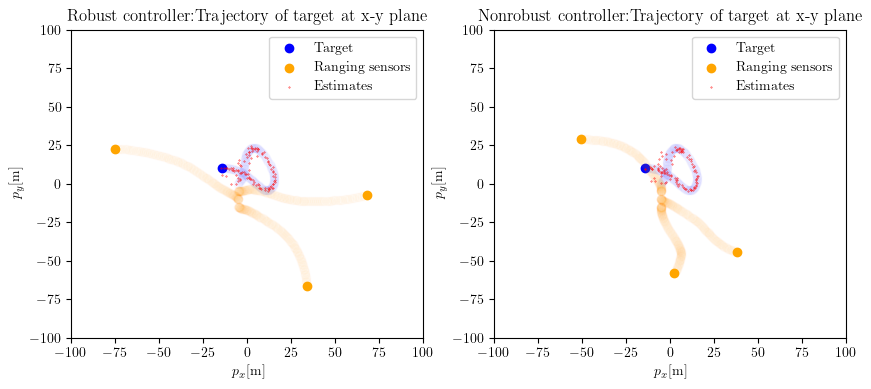

In [125]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(target_1[:,0,:], target_1[:,1,:],c='blue',alpha=0.02)
plt.scatter(target_1[-1,0,:], target_1[-1,1,:],c='blue',alpha=1,label='Target')
plt.scatter(sensors_1[:,0,:], sensors_1[:,1,:], alpha=0.02,c='orange')
plt.scatter(sensors_1[-1,0,:], sensors_1[-1,1,:], alpha=1,c='orange',label='Ranging sensors')
plt.scatter(est_1[:,0,:], est_1[:,1,:], alpha=1,c='red',s=0.1,label='Estimates')
plt.title('Robust controller:Trajectory of target at x-y plane')
plt.xlim(-100,100)
plt.ylim(-100,100)
plt.xlabel('$p_x$[m]')
plt.ylabel('$p_y$[m]')
plt.legend()

plt.subplot(1,2,2)
plt.scatter(target_3[:,0,:], target_3[:,1,:],c='blue',alpha=0.02)
plt.scatter(target_3[-1,0,:], target_3[-1,1,:],c='blue',alpha=1,label='Target')
plt.scatter(sensors_3[:,0,:], sensors_3[:,1,:], alpha=0.02,c='orange')
plt.scatter(sensors_3[-1,0,:], sensors_3[-1,1,:], alpha=1,c='orange',label='Ranging sensors')
plt.scatter(est_3[:,0,:], est_3[:,1,:], alpha=1,c='red',s=0.1,label='Estimates')
plt.title('Nonrobust controller:Trajectory of target at x-y plane')
plt.xlim(-100,100)
plt.ylim(-100,100)
plt.xlabel('$p_x$[m]')
plt.ylabel('$p_y$[m]')
plt.legend()
plt.savefig('one-target-trajectory.pdf')

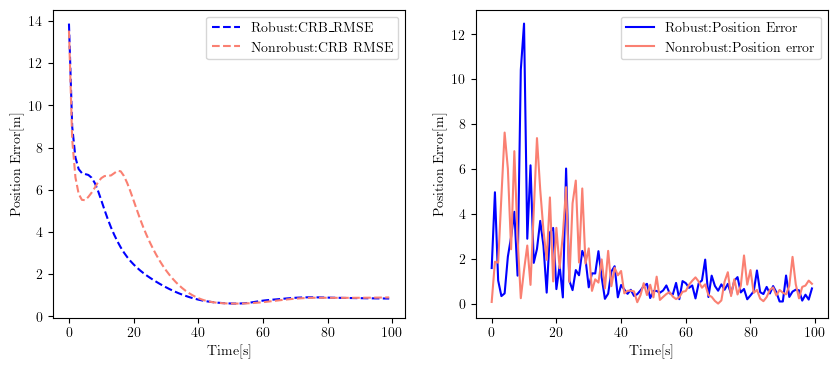

In [131]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(crb_p_1,c='b',linestyle='dashed',label='Robust:CRB_RMSE')
plt.plot(crb_p_3,c='salmon',linestyle='dashed',label='Nonrobust:CRB RMSE')
plt.xlabel('Time[s]')
plt.ylabel('Position Error[m]')
plt.legend()
plt.subplot(1,2,2)
plt.plot(cost_1,c='b',label='Robust:Position Error')
plt.plot(cost_3,c='salmon',label='Nonrobust:Position error')
plt.xlabel('Time[s]')
plt.ylabel('Position Error[m]')
plt.legend()

In [632]:
#mc3 = []
#mc1 = []
#mc2 = []
#mc4 = []
M = 6
for i in range(M):
    print('i=',str(i))
    trajectory = trajectory2D_2
    previous_est = array([[-10.,3, 0, 0]]).T
    
    try:
        
        frames_1 = tracking_smooth(K,3,lr_s,lr_t,w2,trajectory,previous_est)
        cost_1,sensors_1,target_1,est_1 = extract_costs(frames_1)
        mc1.append(cost_1)
    except:
        print('?',str(i))
   # try:   
   #     frames_2 = tracking_smooth(K,1,lr_s,lr_t,w2[:1],trajectory,previous_est,robust=False)
   #     cost_2,sensors_2,target_2,est_2 = extract_costs(frames_2)
   #     mc2.append(cost_2)
   # except:
   #     print('?',str(i))
        
   # try:   
   #     frames_3 = tracking_smooth(K,3,lr_s,lr_t,w2,trajectory,previous_est,robust=False)
   #     cost_3,sensors_3,target_3,est_3 = extract_costs(frames_3)
   #     mc3.append(cost_3)
   # except:
   #     print('?',str(i))
        

i= 0
i= 1
i= 2
i= 3
i= 4
? 4
i= 5
? 5


In [633]:
len(mc1)

100

In [421]:
len(mc2)



108

In [422]:
len(mc3)


117

In [634]:
import pickle
with open('single_target_ranging_sensor_3.pk','wb') as f:
    pickle.dump(np.array(mc1[:100]),f)
#single_target_ranging_sensor_2_ekf
#with open('single_target_ranging_sensor_2_nonrobust_1step.pk','wb') as f:
#    pickle.dump(np.array(mc2[:100]),f)

#with open('single_target_ranging_sensor_2_nonrobust.pk','wb') as f:
#    pickle.dump(np.array(mc3[:100]),f)
    

In [635]:
with open('single_target_ranging_sensor_2.pk','rb') as f:
    costs_mc1=pickle.load(f)
    
with open('single_target_ranging_sensor_2_nonrobust_1step.pk','rb') as f:
    costs_mc2=pickle.load(f)

with open('single_target_ranging_sensor_2_nonrobust.pk','rb') as f:
    costs_mc3=pickle.load(f)
    
with open('single_target_ranging_sensor_3.pk','rb') as f:
    costs_mc4=pickle.load(f)
    

In [636]:
costs_mc_std1 = costs_mc1.std(axis=0)
costs_mc_mean1 = costs_mc1.mean(axis=0)
costs_mc_q_51 = np.quantile(costs_mc1,0.05,axis=0)
costs_mc_q_951= np.quantile(costs_mc1,0.95,axis=0)

costs_mc_std2 = costs_mc2.std(axis=0)
costs_mc_mean2 = costs_mc2.mean(axis=0)
costs_mc_q_52 = np.quantile(costs_mc2,0.05,axis=0)
costs_mc_q_952= np.quantile(costs_mc2,0.95,axis=0)

costs_mc_std3 = costs_mc3.std(axis=0)
costs_mc_mean3 = costs_mc3.mean(axis=0)
costs_mc_q_53 = np.quantile(costs_mc3,0.05,axis=0)
costs_mc_q_953= np.quantile(costs_mc3,0.95,axis=0)

costs_mc_std4 = costs_mc4.std(axis=0)
costs_mc_mean4 = costs_mc4.mean(axis=0)
costs_mc_q_54 = np.quantile(costs_mc4,0.05,axis=0)
costs_mc_q_954= np.quantile(costs_mc4,0.95,axis=0)

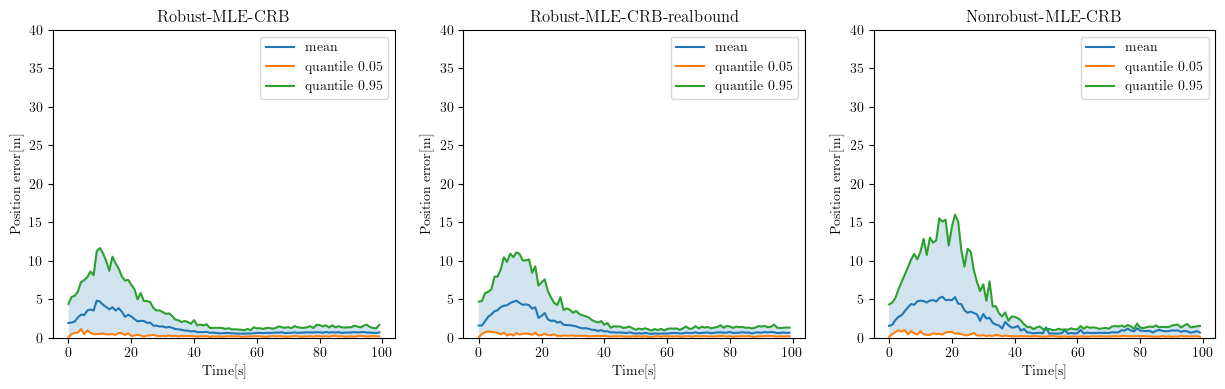

In [637]:
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.plot(costs_mc_mean1,label='mean')
plt.plot(costs_mc_q_51,label='quantile 0.05')
plt.plot(costs_mc_q_951,label='quantile 0.95')
plt.xlabel('Time[s]')
plt.fill_between(range(100),costs_mc_q_51.flatten(), costs_mc_q_951.flatten(),alpha=0.2)
plt.ylabel('Position error[m]')
plt.title('Robust-MLE-CRB')
plt.ylim(0,40)
plt.legend()

plt.subplot(1,3,2)
plt.plot(costs_mc_mean4,label='mean')
plt.plot(costs_mc_q_54,label='quantile 0.05')
plt.plot(costs_mc_q_954,label='quantile 0.95')
plt.xlabel('Time[s]')
plt.fill_between(range(100),costs_mc_q_54.flatten(), costs_mc_q_954.flatten(),alpha=0.2)
plt.ylabel('Position error[m]')
plt.title('Robust-MLE-CRB-realbound')
plt.ylim(0,40)
plt.legend()


plt.subplot(1,3,3)
plt.plot(costs_mc_mean3,label='mean')
plt.plot(costs_mc_q_53,label='quantile 0.05')
plt.plot(costs_mc_q_953,label='quantile 0.95')
plt.xlabel('Time[s]')
plt.fill_between(range(100),costs_mc_q_53.flatten(), costs_mc_q_953.flatten(),alpha=0.2)
plt.ylabel('Position error[m]')
plt.title('Nonrobust-MLE-CRB')
plt.ylim(0,40)
plt.legend()

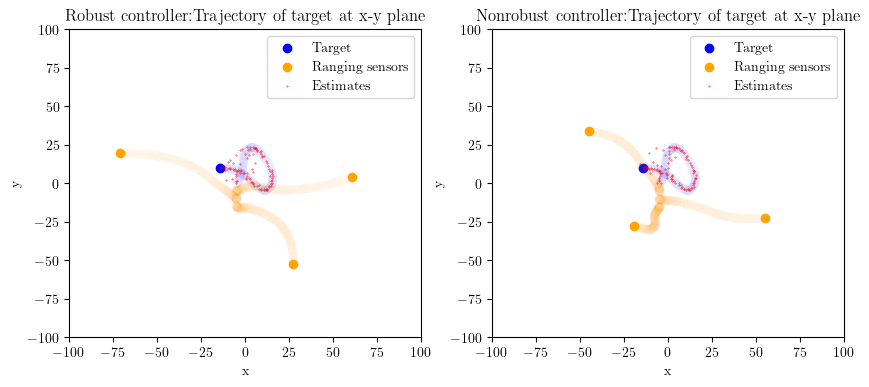

In [643]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(target_1[:,0,:], target_1[:,1,:],c='blue',alpha=0.02)
plt.scatter(target_1[-1,0,:], target_1[-1,1,:],c='blue',alpha=1,label='Target')
plt.scatter(sensors_1[:,0,:], sensors_1[:,1,:], alpha=0.02,c='orange')
plt.scatter(sensors_1[-1,0,:], sensors_1[-1,1,:], alpha=1,c='orange',label='Ranging sensors')
plt.scatter(est_1[:,0,:], est_1[:,1,:], alpha=1,c='red',s=0.1,label='Estimates')
plt.title('Robust controller:Trajectory of target at x-y plane')
plt.xlim(-100,100)
plt.ylim(-100,100)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

plt.subplot(1,2,2)
plt.scatter(target_3[:,0,:], target_3[:,1,:],c='blue',alpha=0.02)
plt.scatter(target_3[-1,0,:], target_3[-1,1,:],c='blue',alpha=1,label='Target')
plt.scatter(sensors_3[:,0,:], sensors_3[:,1,:], alpha=0.02,c='orange')
plt.scatter(sensors_3[-1,0,:], sensors_3[-1,1,:], alpha=1,c='orange',label='Ranging sensors')
plt.scatter(est_3[:,0,:], est_3[:,1,:], alpha=1,c='red',s=0.1,label='Estimates')
plt.title('Nonrobust controller:Trajectory of target at x-y plane')
plt.xlim(-100,100)
plt.ylim(-100,100)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.savefig('one-target-trajectory.pdf')


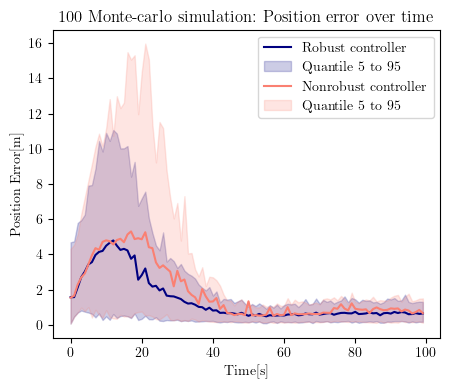

In [642]:
plt.figure(figsize=(5,4))
plt.title('100 Monte-carlo simulation: Position error over time')
plt.plot(costs_mc_mean4,c='navy',label='Robust controller')
plt.fill_between(range(100),costs_mc_q_54.flatten(), costs_mc_q_954.flatten(),alpha=0.2,color='navy',label='Quantile 5 to 95')
plt.plot(costs_mc_mean3,label='Nonrobust controller',c='salmon')
plt.fill_between(range(100),costs_mc_q_53.flatten(), costs_mc_q_953.flatten(),alpha=0.2,color='salmon',label='Quantile 5 to 95')
plt.xlabel('Time[s]')
plt.ylabel('Position Error[m]')
plt.legend()
plt.savefig('one-target-mc.pdf')

In [619]:
def smooth_3D_trajectory(K):
    x_s = torch.zeros((6,6))
    
    x_s[0,0] = 0.01
    x_s[0,1] = -0.01
    x_s[0,2] = 0.0
    x_s[0,3] = 0.02
    x_s[0,4] = -0.02
    x_s[0,5] = -0.015
    
    #x_s[0,6] = 0.015
    #x_s[0,7] = 0.03
    
    x_s[1,0] = 0
    x_s[1,1] = -5
    x_s[1,2] = -10
    x_s[1,3] = -2.5
    x_s[1,4] = -7.5
    x_s[1,5] = -12.5
    #x_s[1,6] = -15
    #x_s[1,7] = -17.5
    
    x_s[2,0] = 5
    x_s[2,1] = -5
  
    x_t = torch.zeros((6,1))
    x_t[0,:] = 0
    x_t[1,:] = -20
    x_t[2,:] = 10
    
    x_t[4,:] = 1
    x_t[5,:] = 0.5
    u_t =  torch.zeros((6,K))
    u_t[3,:] = 0.01
    return x_t,x_s,u_t

def smooth_3D_trajectory_2(K):
    x_s = torch.zeros((6,6))
    
    x_s[0,0] = 0.01
    x_s[0,1] = -0.1
    x_s[0,2] = 0.0
    x_s[0,3] = 0.013
    x_s[0,4] = -0.12
    x_s[0,5] = 0.03
    
    x_s[1,0] = 0
    x_s[1,1] = -5
    x_s[1,2] = -10
    x_s[1,3] = -2.5
    x_s[1,4] = -7.5
    x_s[1,5] = -12.5
    
    x_s[2,0] = 5
    x_s[2,1] = -5
    x_s[2,5] = 6
  
    x_t = torch.zeros((6,1))
    x_t[0,:] = 0
    x_t[1,:] = 10
    x_t[2,:] = 10
    
    x_t[3,:] = 0.5
    
    u_t =  torch.zeros((6,1,K))
    u_t[3,:,:] = -1/K
    u_t[4,:,:int(K/2)] = -1/K
    u_t[4,:,int(K/2):] = 1/K
    return x_t,x_s,u_t

def smooth_3D_trajectory_3(K):
    x_s = torch.zeros((6,7))
    
    x_s[0,0] = 0.01
    x_s[0,1] = -0.01
    x_s[0,2] = 0.0
    x_s[0,3] = 0.02
    x_s[0,4] = -0.02
    x_s[0,5] = -0.015
    x_s[0,6] = 0.001
    
    x_s[1,0] = 0
    x_s[1,1] = -5
    x_s[1,2] = -10
    x_s[1,3] = -2.5
    x_s[1,4] = -7.5
    x_s[1,5] = -12.5
    x_s[1,6] = 2.5
    
    x_s[2,0] = 5
    x_s[2,1] = -5
    x_s[2,2] = 20
  
    x_t = torch.zeros((6,2))
    x_t[0,:] = 0
    x_t[1,:] = 10
    x_t[2,:] = 10
    
    x_t[3,:] = 0.5
    #x_t[5,:] = 0.5
    
    u_t =  torch.zeros((6,2,K))
    u_t[3,:,:] = -1/K
    u_t[4,0,:int(K/2)] = -1/K
    u_t[4,0,int(K/2):] = 1/K
    u_t[4,1,:int(K/2)] = 1/K
    u_t[4,1,int(K/2):] = -1/K
    return x_t,x_s,u_t

def smooth_3D_trajectory_4(K):
    x_s = torch.zeros((6,7))
    
    x_s[0,0] = 0.01
    x_s[0,1] = -0.01
    x_s[0,2] = 0.0
    x_s[0,3] = 0.02
    x_s[0,4] = -0.02
    x_s[0,5] = -0.015
    x_s[0,6] = 0.001
    
    x_s[1,0] = 0
    x_s[1,1] = -5
    x_s[1,2] = -10
    x_s[1,3] = -2.5
    x_s[1,4] = -7.5
    x_s[1,5] = -12.5
    x_s[1,6] = 2.5
    
    x_s[2,0] = 5
    x_s[2,1] = -5
    x_s[2,2] = 20
  
    x_t = torch.zeros((6,2))
    x_t[0,:] = 0
    x_t[1,0] = 10
    x_t[2,:] = 10
    x_t[1,1] = 0
    x_t[3,:] = 0.5
    #x_t[5,:] = 0.5
    
    u_t =  torch.zeros((6,2,K))
    u_t[3,:,:] = -1/K
    u_t[4,0,:int(K/2)] = -1/K
    u_t[4,0,int(K/2):] = 1/K
    
    u_t[4,1,:int(K/2)] = -1/K
    u_t[4,1,int(K/2):] = 1/K
    return x_t,x_s,u_t

def smooth_3D_trajectory_5(K):
    x_s = torch.zeros((6,4))
    
    x_s[0,0] = 0.01
    x_s[0,1] = -0.01
    x_s[0,2] = 0.0
    x_s[0,3] = 0.02
    
    x_s[1,0] = 0
    x_s[1,1] = -5
    x_s[1,2] = -10
    x_s[1,3] = -2.5
    
    x_s[2,0] = 5
    x_s[2,1] = -5
    x_s[2,2] = 20
  
    x_t = torch.zeros((6,2))
    x_t[0,:] = 0
    x_t[1,:] = 10
    x_t[2,:] = 10
    
    x_t[3,:] = 0.5
    #x_t[5,:] = 0.5
    
    u_t =  torch.zeros((6,2,K))
    u_t[3,:,:] = -1/K
    u_t[4,0,:int(K/2)] = -1/K
    u_t[4,0,int(K/2):] = 1/K
    u_t[4,1,:int(K/2)] = 1/K
    u_t[4,1,int(K/2):] = -1/K
    return x_t,x_s,u_t

def smooth_3D_trajectory_6(K):
    x_s = torch.zeros((6,4))
    
    x_s[0,0] = 0.01
    x_s[0,1] = -0.01
    x_s[0,2] = 0.0
    x_s[0,3] = 0.02
    
    x_s[1,0] = 2.5
    x_s[1,1] = -2.5
    x_s[1,2] = -5
    x_s[1,3] = 5
    
    x_s[2,0] = 5
    x_s[2,1] = -5
    x_s[2,2] = 20
  
    x_t = torch.zeros((6,2))
    x_t[0,:] = 0
    x_t[1,:] = 10
    x_t[2,:] = 10
    
    
    _,_,_,u1 = trajectory_spiral_3D(np.array([0,10,10]),K+1,1)
    _,_,_,u2 = trajectory_spiral_3D(np.array([0,10,10]),K+1,-1)
    
    u_t =  torch.zeros((6,2,K))
    u_t[3,0,:] = torch.tensor(u1[:,0])
    u_t[4,0,:] = torch.tensor(u1[:,1])
    u_t[5,0,:] = torch.tensor(u1[:,2])
    u_t[3,1,:] = torch.tensor(u2[:,0])
    u_t[4,1,:] = torch.tensor(u2[:,1])
    u_t[5,1,:] = torch.tensor(u2[:,2])
    return x_t,x_s,u_t

def smooth_3D_trajectory_7(K):
    x_s = torch.zeros((6,7))
    
    x_s[0,0] = 0.01
    x_s[0,1] = -0.01
    x_s[0,2] = 0.0
    x_s[0,3] = 0.013
    x_s[0,4] = -0.12
    x_s[0,5] = 0.01
    
    x_s[1,0] = 0
    x_s[1,1] = -5
    x_s[1,2] = -10
    x_s[1,3] = -2.5
    x_s[1,4] = -7.5
    x_s[1,5] = -8
    x_s[1,6] = -10
    
    x_s[2,0] = 5
    x_s[2,1] = -5
    x_s[2,5] = 9
  
    x_t = torch.zeros((6,1))
    x_t[0,:] = 0
    x_t[1,:] = 10
    x_t[2,:] = 10
    
    x_t[3,:] = 0.5
    
    u_t =  torch.zeros((6,1,K))
    u_t[3,:,:] = -1/K
    u_t[4,:,:int(K/2)] = -1/K
    u_t[4,:,int(K/2):] = 1/K
    return x_t,x_s,u_t


def smooth_3D_trajectory_8(K):
    x_s = torch.zeros((6,7))
    
    x_s[0,0] = 0.01
    x_s[0,1] = -0.01
    x_s[0,2] = 0.0
    x_s[0,3] = 0.013
    x_s[0,4] = -0.
    x_s[0,5] = 0.01
    
    x_s[1,0] = 0
    x_s[1,1] = -5
    x_s[1,2] = -10
    x_s[1,3] = -2.5
    x_s[1,4] = -0.001
    x_s[1,5] = -0.02
    x_s[1,6] = 0
    
    x_s[2,0] = 5
    x_s[2,1] = -5
    x_s[2,5] = 9
  
    x_t = torch.zeros((6,1))
    x_t[0,:] = 50
    x_t[1,:] = 0
    x_t[2,:] = 10
    
    x_t[3,:] = 0
    
    u_t =  torch.zeros((6,1,K))
    
    xs,ys,zs,us = trajactory_Tangential_3D(np.array([50,0,10]),K,50,4*np.pi)
    
    u_t[3,:,:] = torch.tensor(us[:,0])
    u_t[4,:,:] = torch.tensor(us[:,1])
    u_t[5,:,:] = torch.tensor(us[:,2])
    return x_t,x_s,u_t

In [624]:
def tracking_3D_smooth(K,T,lr_s,lr_t,w,trajectory,est_0,ekf=False,kappa=1):
    global sensor_helper
    global sensor_simulator
    frames = []
    
    x_t,x_s,u_t = trajectory(K)
    previous_est = est_0
    x_t_n = x_t.numpy()
    x_s_n = x_s.numpy()
    sensor_simulator.states = x_s_n
    #print(x_s)
    for k in range(K):
        #print(k)
        t1 = time()
        frame = {}
        
        x_t_n = x_t.numpy()
        x_s_n = x_s.numpy()
        
        frame['target'] = x_t_n
        frame['sensor'] = x_s_n
        
        #STEP 1. read observaion
        obs = observe(sensor_simulator.hx(x_t_n),sensor_simulator.sx(x_t_n))
        frame['obs'] = obs
        
        #STEP 2. estimate target
        est,C_sqt = estimate_mle(sensor_simulator,obs,previous_est)
       
        if isinstance(sensor_simulator,RangingSensors3D) or isinstance(sensor_simulator,RangingSensors3D_2):
            velocity = sensor_helper.estimate_velocity(est,previous_est) 
            est[3:,:] = velocity
    
        
        frame['est'] = est
        frame['abs_err'] = sensor_helper.abs_err(x_t_n,est)
        frame['velocity_err'] = np.linalg.norm(x_t_n[3:,:]-est[3:,:],axis=0)
        
        
        x_s_n_prev = x_s_n.copy()
        previous_est = est.copy()
        
        #STEP 3. plan nextmove
        u_s,_ = robustmove(T,x_s,torch.tensor(est),lr_s,lr_t,torch.tensor(C_sqt),w,ekf=ekf,kappa=kappa)
        
        #print(u_s)
        #STEP 4. sensor act
        x_s = sensor_helper.transition(x_s,u_s[0])
        x_s_n = x_s.numpy()
        sensor_simulator.states = x_s_n
        
        #STEP 5. target act
        x_t = sensor_helper.transition_target(x_t,u_t[:,:,k])
        x_t_n = x_t.numpy()
        
        #6. evaluate 
        crb_rmse_p,crb_rmse_v = crlb_rmse(sensor_simulator.hx(x_t_n),sensor_simulator.sx(x_t_n),sensor_simulator.H(x_t_n),sensor_simulator.S(x_t_n))
        frame['crb_rmse_p'] = crb_rmse_p
        frame['crb_rmse_v'] = crb_rmse_v
        
        frame['k'] = k
        #print(time()-t1)
        frames.append(frame)
    return frames

def tracking_3D_smooth_static(K,T,lr_s,lr_t,w,trajectory,est_0):
    global sensor_helper
    global sensor_simulator
    frames = []
    
    x_t,x_s,u_t = trajectory(K)
    previous_est = est_0
    x_t_n = x_t.numpy()
    x_s_n = x_s.numpy()
    sensor_simulator.states = x_s_n
    #print(x_s)
    for k in range(K):
        #print(k)
        t1 = time()
        frame = {}
        
        x_t_n = x_t.numpy()
        #x_s_n = x_s.numpy()
        
        frame['target'] = x_t_n
        frame['sensor'] = x_s_n
        
        #STEP 1. read observaion
        obs = observe(sensor_simulator.hx(x_t_n),sensor_simulator.sx(x_t_n))
        frame['obs'] = obs
        
        #STEP 2. estimate target
        est,C_sqt = estimate_mle(sensor_simulator,obs,previous_est)
       
        if isinstance(sensor_simulator,RangingSensors3D) or isinstance(sensor_simulator,RangingSensors3D_2):
            velocity = sensor_helper.estimate_velocity(est,previous_est) 
            est[3:,:] = velocity
    
        
        frame['est'] = est
        frame['abs_err'] = sensor_helper.abs_err(x_t_n,est)
        frame['velocity_err'] = np.sqrt(((x_t_n[3:,:]-est[3:,:])**2).sum())
        
        
        x_s_n_prev = x_s_n.copy()
        previous_est = est.copy()
        
        #STEP 5. target act
        x_t = sensor_helper.transition_target(x_t,u_t[:,:,k])
        x_t_n = x_t.numpy()
        
        #6. evaluate 
        crb_rmse_p,crb_rmse_v = crlb_rmse(sensor_simulator.hx(x_t_n),sensor_simulator.sx(x_t_n),sensor_simulator.H(x_t_n),sensor_simulator.S(x_t_n))
        frame['crb_rmse_p'] = crb_rmse_p
        frame['crb_rmse_v'] = crb_rmse_v
        
        frame['k'] = k
        print(k)
        frames.append(frame)
    return frames

In [625]:
K = 100
range_u_s = [-0.02,0.02]
range_u_t = [-0.01,0.01]
lr_t = 0.01
lr_s = 0.03
w2 = torch.tensor([0.5,0.3,0.2])



In [626]:


n_range_sensors = 4
n_doppler_sensors = 3
sensor_helper = EnsembledSensor3DTorchUtils_2(n_range_sensors)
sensor_simulator = EnsembledSensors3D_2(n_range_sensors,zeros((6,7)))


previous_est = array([[15 ,2 ,15 ,0, 0, 0]]).T#

frames_6 = tracking_3D_smooth(400,3,lr_s,lr_t,w2,smooth_3D_trajectory_8,previous_est)

In [636]:

cost_6,sensors_6,target_6,est_6,velo_6,crb_rmse_p_6,crb_rmse_v_6 = extract_costs(frames_6,True)

In [ ]:

n_range_sensors = 4
n_doppler_sensors = 3
sensor_helper = EnsembledSensor3DTorchUtils_2(n_range_sensors)
sensor_simulator = EnsembledSensors3D_2(n_range_sensors,zeros((6,7)))


previous_est = array([[15 ,2 ,15 ,0, 0, 0]]).T#

frames_6s = tracking_3D_smooth_static(K*4,3,lr_s,lr_t,w2,smooth_3D_trajectory_8,previous_est)

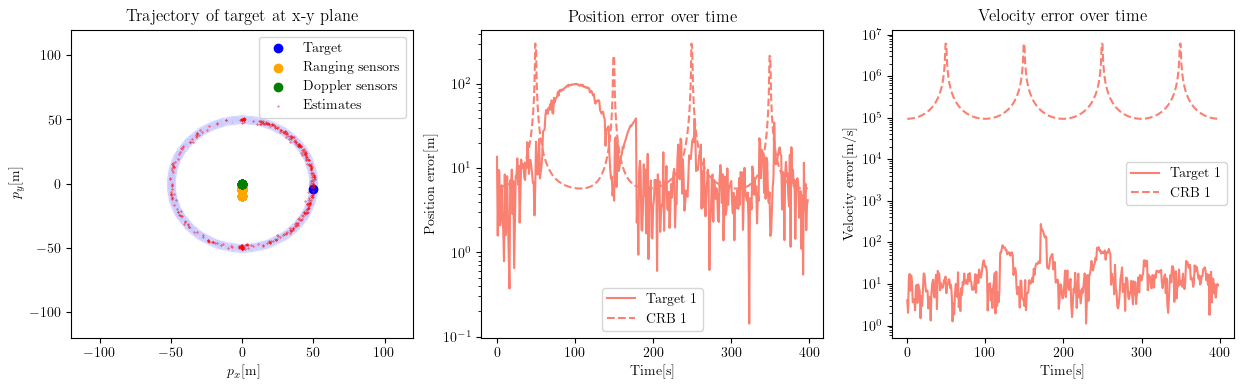

In [637]:

cost_6s,sensors_6s,target_6s,est_6s,velo_6s,crb_rmse_p_6s,crb_rmse_v_6s = extract_costs(frames_6s,True)

plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.scatter(target_6s[:,0,:], target_6s[:,1,:],c='blue',alpha=0.02)
plt.scatter(target_6s[-1,0,:], target_6s[-1,1,:],c='blue',alpha=1,label='Target')

plt.scatter(sensors_6s[:,0,:n_range_sensors], sensors_6s[:,1,:n_range_sensors], alpha=0.02,c='orange')
plt.scatter(sensors_6s[-1,0,:n_range_sensors], sensors_6s[-1,1,:n_range_sensors], alpha=1,c='orange',label='Ranging sensors')
plt.scatter(sensors_6s[:,0,n_range_sensors:], sensors_6s[:,1,n_range_sensors:], alpha=0.02,c='green')
plt.scatter(sensors_6s[-1,0,n_range_sensors:], sensors_6s[-1,1,n_range_sensors:], alpha=1,c='green',label='Doppler sensors')

plt.scatter(est_6s[:,0,:], est_6s[:,1,:], alpha=1,c='red',s=0.1,label='Estimates')


plt.title('Trajectory of target at x-y plane')
plt.xlim(-120,120)
plt.ylim(-120,120)
plt.xlabel('$p_x$[m]')
plt.ylabel('$p_y$[m]')
plt.legend(loc='best')

plt.subplot(1,3,2)
plt.plot(np.array(cost_6s)[1:],c='salmon',label='Target 1')
plt.plot(crb_rmse_p_6s[1:],c='salmon',linestyle='dashed',label='CRB 1')
#plt.plot(np.array(cost_6)[1:,1],c='navy',label='Target 2')
#plt.plot(crb_rmse_p_6[1:,1],c='navy',linestyle='dashed',label='CRB 2')
plt.xlabel('Time[s]')
plt.ylabel('Position error[m]')
plt.title('Position error over time')
plt.legend(loc='best')
plt.yscale('log')

plt.subplot(1,3,3)
plt.plot(np.array(velo_6s)[1:],c='salmon',label='Target 1')
plt.plot(crb_rmse_v_6s[1:],c='salmon',linestyle='dashed',label='CRB 1')
#plt.plot(np.array(cost_6)[1:,1],c='navy',label='Target 2')
#plt.plot(crb_rmse_p_6[1:,1],c='navy',linestyle='dashed',label='CRB 2')
plt.xlabel('Time[s]')
plt.ylabel('Velocity error[m/s]')
plt.title('Velocity error over time')
plt.legend(loc='best')
plt.yscale('log')
#plt.savefig('two-targets-mix.pdf')

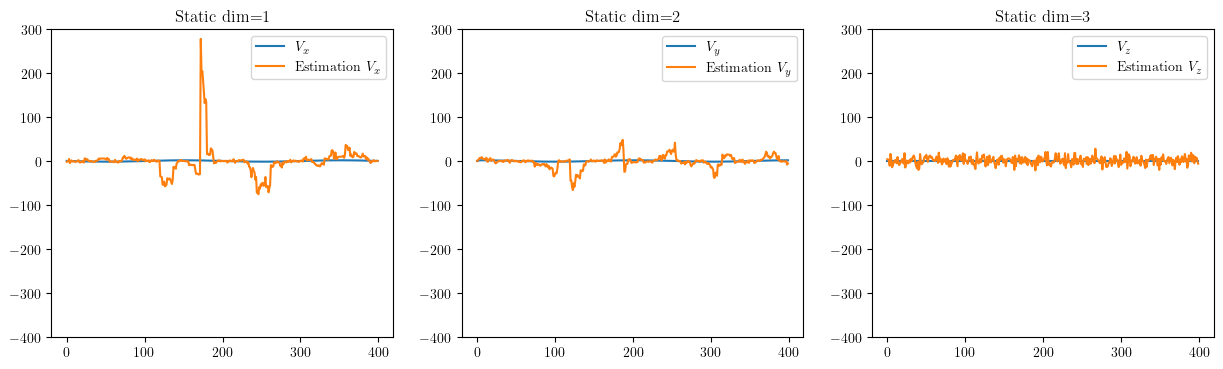

In [639]:
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.title('Static dim=1')
plt.plot(target_6s[:,3,0],c='C0',label='$V_x$')
plt.plot(est_6s[:,3,0],c='C1',label='Estimation $V_x$')
plt.ylim(-400,300)
plt.legend()

plt.subplot(1,3,2)
plt.title('Static dim=2')
plt.plot(target_6s[:,4,0],c='C0',label='$V_y$')
plt.plot(est_6s[:,4,0],c='C1',label='Estimation $V_y$')
plt.ylim(-400,300)
plt.legend()

plt.subplot(1,3,3)
plt.title('Static dim=3')
plt.plot(target_6s[:,5,0],c='C0',label='$V_z$')
plt.plot(est_6s[:,5,0],c='C1',label='Estimation $V_z$')
plt.ylim(-400,300)
plt.legend()

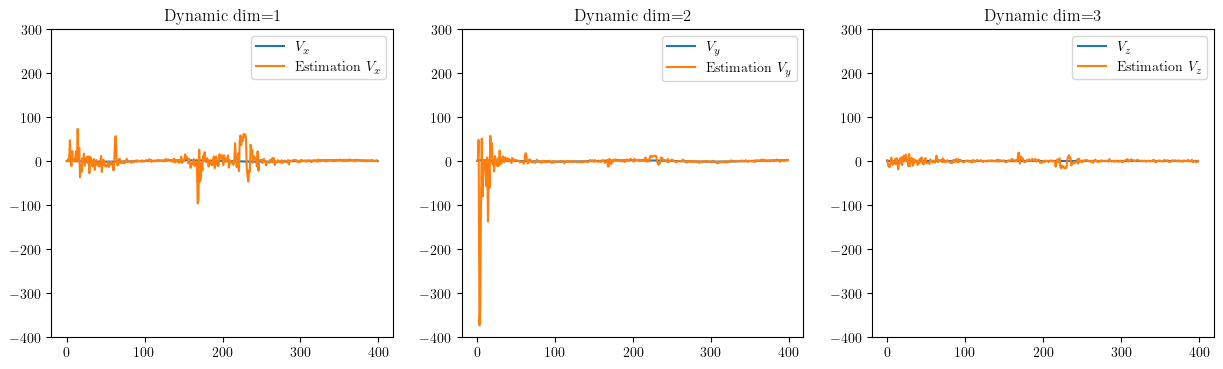

In [640]:
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.title('Dynamic dim=1')
plt.plot(target_6[:,3,0],c='C0',label='$V_x$')
plt.plot(est_6[:,3,0],c='C1',label='Estimation $V_x$')
plt.ylim(-400,300)
plt.legend()

plt.subplot(1,3,2)
plt.title('Dynamic dim=2')
plt.plot(target_6[:,4,0],c='C0',label='$V_y$')
plt.plot(est_6[:,4,0],c='C1',label='Estimation $V_y$')
plt.ylim(-400,300)
plt.legend()

plt.subplot(1,3,3)
plt.title('Dynamic dim=3')
plt.plot(target_6[:,5,0],c='C0',label='$V_z$')
plt.plot(est_6[:,5,0],c='C1',label='Estimation $V_z$')
plt.ylim(-400,300)
plt.legend()

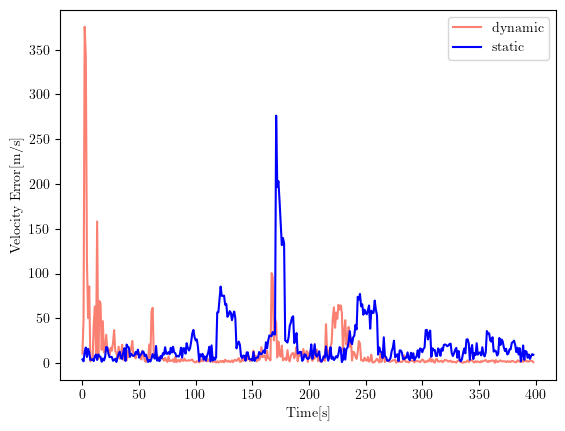

In [641]:

plt.plot(velo_6[1:],c='salmon',label='dynamic')
plt.plot(velo_6s[1:],c='blue',label='static')
plt.ylabel('Velocity Error[m/s]')
plt.xlabel('Time[s]')
plt.legend()

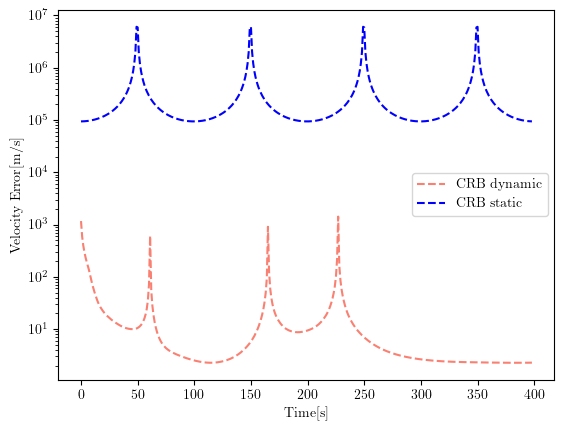

In [642]:

plt.plot(crb_rmse_v_6[1:],c='salmon',linestyle='dashed',label='CRB dynamic')
plt.plot(crb_rmse_v_6s[1:],c='blue',linestyle='dashed',label='CRB static')
plt.yscale('log')
plt.ylabel('Velocity Error[m/s]')
plt.xlabel('Time[s]')
plt.legend()

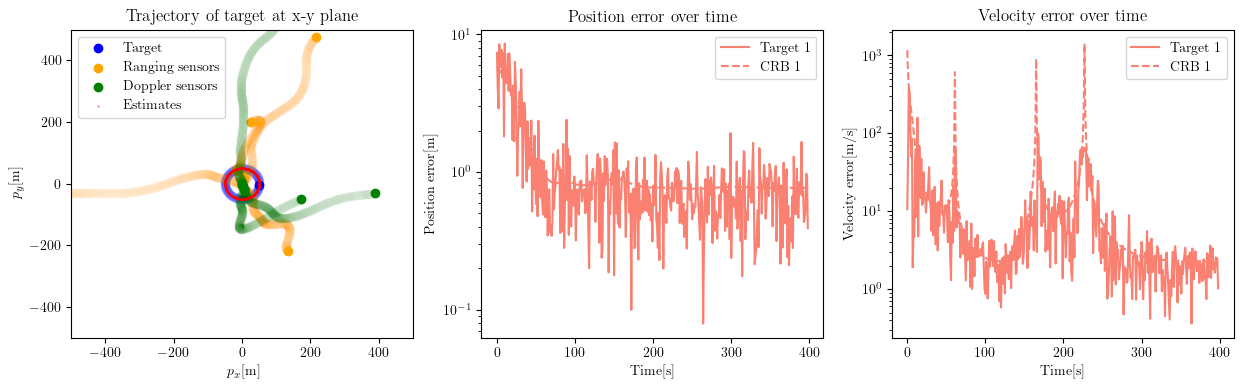

In [638]:
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.scatter(target_6[:,0,:], target_6[:,1,:],c='blue',alpha=0.02)
plt.scatter(target_6[-1,0,:], target_6[-1,1,:],c='blue',alpha=1,label='Target')

plt.scatter(sensors_6[:,0,:n_range_sensors], sensors_6[:,1,:n_range_sensors], alpha=0.02,c='orange')
plt.scatter(sensors_6[-1,0,:n_range_sensors], sensors_6[-1,1,:n_range_sensors], alpha=1,c='orange',label='Ranging sensors')
plt.scatter(sensors_6[:,0,n_range_sensors:], sensors_6[:,1,n_range_sensors:], alpha=0.02,c='green')
plt.scatter(sensors_6[-1,0,n_range_sensors:], sensors_6[-1,1,n_range_sensors:], alpha=1,c='green',label='Doppler sensors')

plt.scatter(est_6[:,0,:], est_6[:,1,:], alpha=1,c='red',s=0.1,label='Estimates')


plt.title('Trajectory of target at x-y plane')
plt.xlim(-500,500)
plt.ylim(-500,500)
plt.xlabel('$p_x$[m]')
plt.ylabel('$p_y$[m]')
plt.legend(loc='best')

plt.subplot(1,3,2)
plt.plot(np.array(cost_6)[1:],c='salmon',label='Target 1')
plt.plot(crb_rmse_p_6[1:],c='salmon',linestyle='dashed',label='CRB 1')
#plt.plot(np.array(cost_6)[1:,1],c='navy',label='Target 2')
#plt.plot(crb_rmse_p_6[1:,1],c='navy',linestyle='dashed',label='CRB 2')
plt.xlabel('Time[s]')
plt.ylabel('Position error[m]')
plt.title('Position error over time')
plt.legend(loc='best')
plt.yscale('log')

plt.subplot(1,3,3)
plt.plot(np.array(velo_6)[1:],c='salmon',label='Target 1')
plt.plot(crb_rmse_v_6[1:],c='salmon',linestyle='dashed',label='CRB 1')
#plt.plot(np.array(cost_6)[1:,1],c='navy',label='Target 2')
#plt.plot(crb_rmse_p_6[1:,1],c='navy',linestyle='dashed',label='CRB 2')
plt.xlabel('Time[s]')
plt.ylabel('Velocity error[m/s]')
plt.title('Velocity error over time')
plt.legend(loc='best')
plt.yscale('log')
#plt.savefig('two-targets-mix.pdf')

In [ ]:
plotgif(400,frames_6,cost_6,[-400,200,-400,200],'zero_doppler',4)

In [ ]:

n_range_sensors = 3
n_doppler_sensors = 3
sensor_helper = EnsembledSensor3DTorchUtils(n_range_sensors)
sensor_simulator = EnsembledSensors3D(n_range_sensors,zeros((6,6)))


previous_est = array([[2 ,-10 ,15 ,0, 0, 0]]).T#

frames_7 = tracking_3D_smooth(K,3,lr_s,lr_t,w2,smooth_3D_trajectory_2,previous_est)
cost_7,sensors_7,target_7,est_7,velo_7,crb_rmse_p_7,crb_rmse_v_7 = extract_costs(frames_7,True)

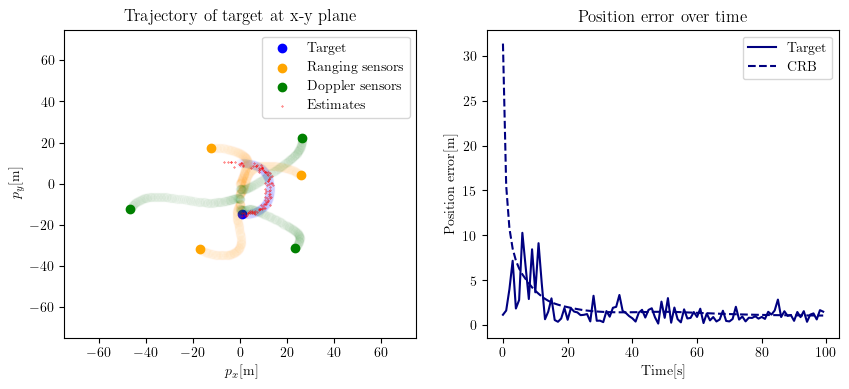

In [61]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(target_7[:,0,:], target_7[:,1,:],c='blue',alpha=0.02)
plt.scatter(target_7[-1,0,:], target_7[-1,1,:],c='blue',alpha=1,label='Target')

plt.scatter(sensors_7[:,0,:n_range_sensors], sensors_7[:,1,:n_range_sensors], alpha=0.02,c='orange')
plt.scatter(sensors_7[-1,0,:n_range_sensors], sensors_7[-1,1,:n_range_sensors], alpha=1,c='orange',label='Ranging sensors')
plt.scatter(sensors_7[:,0,n_range_sensors:], sensors_7[:,1,n_range_sensors:], alpha=0.02,c='green')
plt.scatter(sensors_7[-1,0,n_range_sensors:], sensors_7[-1,1,n_range_sensors:], alpha=1,c='green',label='Doppler sensors')

plt.scatter(est_7[:,0,:], est_7[:,1,:], alpha=1,c='red',s=0.1,label='Estimates')


plt.title('Trajectory of target at x-y plane')
plt.xlim(-75,75)
plt.ylim(-75,75)
plt.xlabel('$p_x$[m]')
plt.ylabel('$p_y$[m]')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(np.array(cost_7)[:,0],c='navy',label='Target')
plt.plot(crb_rmse_p_7[:,0],c='navy',linestyle='dashed',label='CRB')
plt.xlabel('Time[s]')
plt.ylabel('Position error[m]')
plt.title('Position error over time')
plt.legend(loc='best')
plt.savefig('one-target-mix.pdf')

In [221]:

n_range_sensors = 3
n_doppler_sensors = 3

range_u_s = [-0.02,0.02]
range_u_t = [-0.01,0.01]

previous_est = array([[2 ,-10 ,15 ,0, 0, 0]]).T#

M = 20
#_cost_k0 = []
#_velo_k0 = []
#_crb_rmse_p_k0 = []
#_crb_rmse_v_k0 = []

    
for i in range(M):
    print('iter',i)
    try:
        sensor_helper = EnsembledSensor3DTorchUtils(n_range_sensors)
        sensor_simulator = EnsembledSensors3D(n_range_sensors,zeros((6,6)))

        frames_k0 = tracking_3D_smooth(K,3,lr_s,lr_t,w2,smooth_3D_trajectory_2,previous_est,kappa=0)
        cost_k0,sensors_k0,target_k0,est_k0,velo_k0,crb_rmse_p_k0,crb_rmse_v_k0 = extract_costs(frames_k0,True)

        _cost_k0.append(array(cost_k0).flatten())
        _velo_k0.append(velo_k0)
        _crb_rmse_p_k0.append(crb_rmse_p_k0.flatten())
        _crb_rmse_v_k0.append(crb_rmse_v_k0.flatten())
    except:
        print('woops')

iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14
iter 15
iter 16
iter 17
iter 18
iter 19


In [222]:
import pickle
with open('kappa_0.pk','wb') as f:
    pickle.dump((_cost_k0[:100],_velo_k0[:100],_crb_rmse_p_k0[:100],_crb_rmse_v_k0[:100]),f)



In [223]:
with open('kappa_0.pk','rb') as f:
    _cost_k0,_velo_k0,_crb_rmse_p_k0,_crb_rmse_v_k0 = pickle.load(f)

In [224]:

n_range_sensors = 3
n_doppler_sensors = 3


range_u_s = [-0.02,0.02]
range_u_t = [-0.01,0.01]

previous_est = array([[2 ,-10 ,15 ,0, 0, 0]]).T#

M = 40
#_cost_k0001 = []
#_velo_k0001 = []
#_crb_rmse_p_k0001 = []
#_crb_rmse_v_k0001 = []
for i in range(M):
    print('iter',i)
    try:
        sensor_helper = EnsembledSensor3DTorchUtils(n_range_sensors)
        sensor_simulator = EnsembledSensors3D(n_range_sensors,zeros((6,6)))

        frames_k0001 = tracking_3D_smooth(K,3,lr_s,lr_t,w2,smooth_3D_trajectory_2,previous_est,kappa=0.001)
        cost_k0001,sensors_k0001,target_k0001,est_k0001,velo_k0001,crb_rmse_p_k0001,crb_rmse_v_k0001 = extract_costs(frames_k0001,True)

        _cost_k0001.append(array(cost_k0001).flatten())
        _velo_k0001.append(velo_k0001)
        _crb_rmse_p_k0001.append(crb_rmse_p_k0001.flatten())
        _crb_rmse_v_k0001.append(crb_rmse_v_k0001.flatten())
    except:
        print('woops')

iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
woops
iter 14
iter 15
iter 16
iter 17
iter 18
iter 19
woops
iter 20
iter 21
iter 22
iter 23
iter 24
woops
iter 25
iter 26
iter 27
iter 28
iter 29
iter 30
iter 31
iter 32
iter 33
iter 34
iter 35
woops
iter 36
iter 37
iter 38
iter 39


In [236]:

with open('kappa_0001.pk','wb') as f:
    pickle.dump((_cost_k0001[:100],_velo_k0001[:100],_crb_rmse_p_k0001[:100],_crb_rmse_v_k0001[:100]),f)

In [237]:

n_range_sensors = 3
n_doppler_sensors = 3


range_u_s = [-0.02,0.02]
range_u_t = [-0.01,0.01]

previous_est = array([[2 ,-10 ,15 ,0, 0, 0]]).T#

M = 20
#_cost_k001 = []
#_velo_k001 = []
#_crb_rmse_p_k001 = []
#_crb_rmse_v_k001 = []
for i in range(M):
    print('iter',i)
    try:
        sensor_helper = EnsembledSensor3DTorchUtils(n_range_sensors)
        sensor_simulator = EnsembledSensors3D(n_range_sensors,zeros((6,6)))

        frames_k001 = tracking_3D_smooth(K,3,lr_s,lr_t,w2,smooth_3D_trajectory_2,previous_est,kappa=0.01)
        cost_k001,sensors_k001,target_k001,est_k001,velo_k001,crb_rmse_p_k001,crb_rmse_v_k001 = extract_costs(frames_k001,True)

        _cost_k001.append(array(cost_k001).flatten())
        _velo_k001.append(velo_k001)
        _crb_rmse_p_k001.append(crb_rmse_p_k001.flatten())
        _crb_rmse_v_k001.append(crb_rmse_v_k001.flatten())
    except:
        print('woops')

iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
woops
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14
woops
iter 15
iter 16
iter 17
iter 18
iter 19


In [ ]:

with open('kappa_001.pk','wb') as f:
    pickle.dump((_cost_k001[:100],_velo_k001[:100],_crb_rmse_p_k001[:100],_crb_rmse_v_k001[:100]),f)

In [214]:

n_range_sensors = 3
n_doppler_sensors = 3


range_u_s = [-0.02,0.02]
range_u_t = [-0.01,0.01]

previous_est = array([[2 ,-10 ,15 ,0, 0, 0]]).T#

M = 20
_cost_k01 = []
_velo_k01 = []
_crb_rmse_p_k01 = []
_crb_rmse_v_k01 = []
for i in range(M):
    print('iter',i)
    try:
        sensor_helper = EnsembledSensor3DTorchUtils(n_range_sensors)
        sensor_simulator = EnsembledSensors3D(n_range_sensors,zeros((6,6)))

        frames_k01 = tracking_3D_smooth(K,3,lr_s,lr_t,w2,smooth_3D_trajectory_2,previous_est,kappa=0.1)
        cost_k01,sensors_k01,target_k01,est_k01,velo_k01,crb_rmse_p_k01,crb_rmse_v_k01 = extract_costs(frames_k01,True)

        _cost_k01.append(array(cost_k01).flatten())
        _velo_k01.append(velo_k01)
        _crb_rmse_p_k01.append(crb_rmse_p_k01.flatten())
        _crb_rmse_v_k01.append(crb_rmse_v_k01.flatten())
    except:
        print('woops')

iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
woops
iter 8
woops
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14
iter 15
iter 16
iter 17
iter 18
woops
iter 19


In [215]:

n_range_sensors = 3
n_doppler_sensors = 3


range_u_s = [-0.02,0.02]
range_u_t = [-0.01,0.01]

previous_est = array([[2 ,-10 ,15 ,0, 0, 0]]).T#

M = 20
_cost_k1 = []
_velo_k1 = []
_crb_rmse_p_k1 = []
_crb_rmse_v_k1 = []
for i in range(M):
    print('iter',i)
    try:
        sensor_helper = EnsembledSensor3DTorchUtils(n_range_sensors)
        sensor_simulator = EnsembledSensors3D(n_range_sensors,zeros((6,6)))

        frames_k1 = tracking_3D_smooth(K,3,lr_s,lr_t,w2,smooth_3D_trajectory_2,previous_est,kappa=1)
        cost_k1,sensors_k1,target_k1,est_k1,velo_k1,crb_rmse_p_k1,crb_rmse_v_k1 = extract_costs(frames_k1,True)

        _cost_k1.append(array(cost_k1).flatten())
        _velo_k1.append(velo_k1)
        _crb_rmse_p_k1.append(crb_rmse_p_k1.flatten())
        _crb_rmse_v_k1.append(crb_rmse_v_k1.flatten())
    except:
        print('woops')

iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
woops
iter 11
iter 12
woops
iter 13
iter 14
iter 15
iter 16
iter 17
iter 18
iter 19


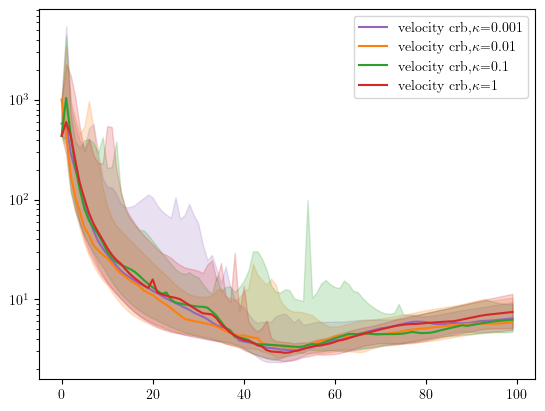

In [229]:

plt.fill_between(range(100),np.quantile(array(_crb_rmse_v_k0),0.1,axis=0), np.quantile(array(_crb_rmse_v_k0),0.9,axis=0),alpha=0.2,color='C0')
plt.plot(np.quantile(array(_crb_rmse_v_k0),0.5,axis=0),color='C0',label='velocity crb,$\kappa$=0')
plt.fill_between(range(100),np.quantile(array(_crb_rmse_v_k0001),0.1,axis=0), np.quantile(array(_crb_rmse_v_k0001),0.9,axis=0),alpha=0.2,color='C4')
plt.plot(np.quantile(array(_crb_rmse_v_k0001),0.5,axis=0),color='C4',label='velocity crb,$\kappa$=0.001')
plt.fill_between(range(100),np.quantile(array(_crb_rmse_v_k001),0.1,axis=0), np.quantile(array(_crb_rmse_v_k001),0.9,axis=0),alpha=0.2,color='C1')
plt.plot(np.quantile(array(_crb_rmse_v_k001),0.5,axis=0),color='C1',label='velocity crb,$\kappa$=0.01')
plt.fill_between(range(100),np.quantile(array(_crb_rmse_v_k01),0.1,axis=0), np.quantile(array(_crb_rmse_v_k01),0.9,axis=0),alpha=0.2,color='C2')
plt.plot(np.quantile(array(_crb_rmse_v_k01),0.5,axis=0),color='C2',label='velocity crb,$\kappa$=0.1')
plt.fill_between(range(100),np.quantile(array(_crb_rmse_v_k1),0.1,axis=0), np.quantile(array(_crb_rmse_v_k1),0.9,axis=0),alpha=0.2,color='C3')
plt.plot(np.quantile(array(_crb_rmse_v_k1),0.5,axis=0),color='C3',label='velocity crb,$\kappa$=1')
plt.yscale('log')
plt.legend()

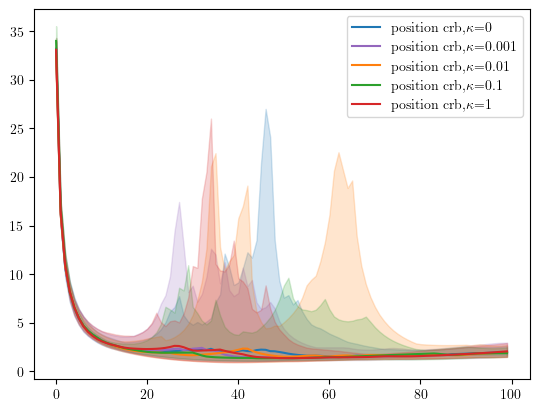

In [233]:

plt.fill_between(range(100),np.quantile(array(_crb_rmse_p_k0),0.1,axis=0), np.quantile(array(_crb_rmse_p_k0),0.9,axis=0),alpha=0.2,color='C0')
plt.plot(np.quantile(array(_crb_rmse_p_k0),0.5,axis=0),color='C0',label='position crb,$\kappa$=0')
plt.fill_between(range(100),np.quantile(array(_crb_rmse_p_k0001),0.1,axis=0), np.quantile(array(_crb_rmse_p_k0001),0.9,axis=0),alpha=0.2,color='C4')
plt.plot(np.quantile(array(_crb_rmse_p_k0001),0.5,axis=0),color='C4',label='position crb,$\kappa$=0.001')
plt.fill_between(range(100),np.quantile(array(_crb_rmse_p_k001),0.1,axis=0), np.quantile(array(_crb_rmse_p_k001),0.9,axis=0),alpha=0.2,color='C1')
plt.plot(np.quantile(array(_crb_rmse_p_k001),0.5,axis=0),color='C1',label='position crb,$\kappa$=0.01')
plt.fill_between(range(100),np.quantile(array(_crb_rmse_p_k01),0.1,axis=0), np.quantile(array(_crb_rmse_p_k01),0.9,axis=0),alpha=0.2,color='C2')
plt.plot(np.quantile(array(_crb_rmse_p_k01),0.5,axis=0),color='C2',label='position crb,$\kappa$=0.1')
plt.fill_between(range(100),np.quantile(array(_crb_rmse_p_k1),0.1,axis=0), np.quantile(array(_crb_rmse_p_k1),0.9,axis=0),alpha=0.2,color='C3')
plt.plot(np.quantile(array(_crb_rmse_p_k1),0.5,axis=0),color='C3',label='position crb,$\kappa$=1')
plt.legend()

Text(0.5, 1.0, 'CRB of position error over time')

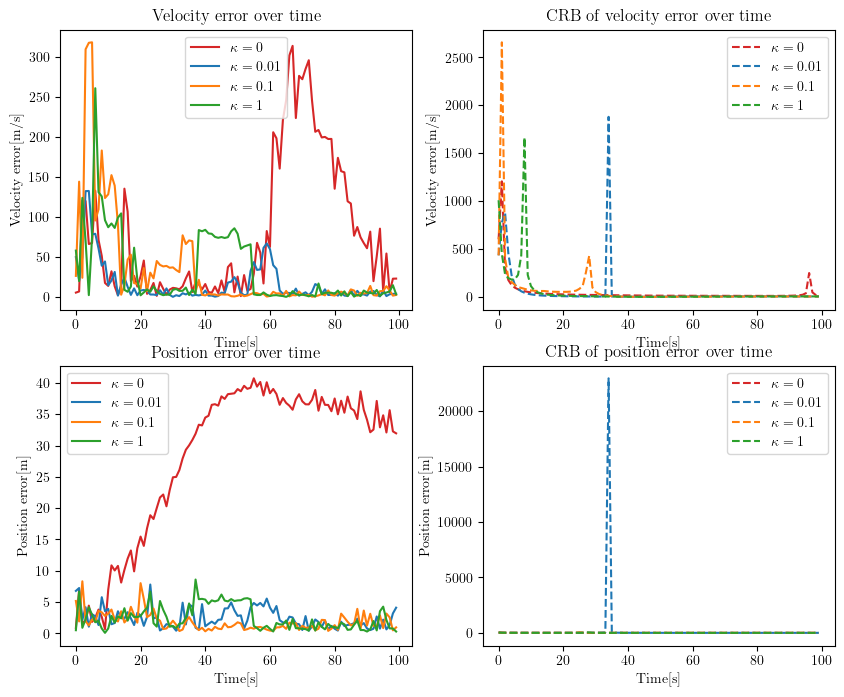

In [169]:
plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
plt.plot(velo_k0,c='C3',label='$\kappa = 0$')
plt.plot(velo_k001,c='C0',label='$\kappa = 0.01$')
plt.plot(velo_k01,c='C1',label='$\kappa = 0.1$')
plt.plot(velo_k1,c='C2',label='$\kappa = 1$')
plt.legend()
plt.xlabel('Time[s]')
plt.ylabel('Velocity error[m/s]')
plt.title('Velocity error over time')


plt.subplot(2,2,2)

plt.plot(crb_rmse_v_k0,c='C3',linestyle='dashed',label='$\kappa = 0$')
plt.plot(crb_rmse_v_k001,c='C0',linestyle='dashed',label='$\kappa = 0.01$')
plt.plot(crb_rmse_v_k01,c='C1',linestyle='dashed',label='$\kappa = 0.1$')
plt.plot(crb_rmse_v_k1,c='C2',linestyle='dashed',label='$\kappa = 1$')
plt.legend()
plt.xlabel('Time[s]')
plt.ylabel('Velocity error[m/s]')
plt.title('CRB of velocity error over time')

plt.subplot(2,2,3)
plt.plot(cost_k0,c='C3',label='$\kappa = 0$')
plt.plot(cost_k001,c='C0',label='$\kappa = 0.01$')
plt.plot(cost_k01,c='C1',label='$\kappa = 0.1$')
plt.plot(cost_k1,c='C2',label='$\kappa = 1$')
plt.legend()
plt.xlabel('Time[s]')
plt.ylabel('Position error[m]')
plt.title('Position error over time')

plt.subplot(2,2,4)
plt.plot(crb_rmse_p_k0,c='C3',linestyle='dashed',label='$\kappa = 0$')
plt.plot(crb_rmse_p_k001,c='C0',linestyle='dashed',label='$\kappa = 0.01$')
plt.plot(crb_rmse_p_k01,c='C1',linestyle='dashed',label='$\kappa = 0.1$')
plt.plot(crb_rmse_p_k1,c='C2',linestyle='dashed',label='$\kappa = 1$')
plt.legend()
#plt.yscale('log')
plt.xlabel('Time[s]')
plt.ylabel('Position error[m]')
plt.title('CRB of position error over time')

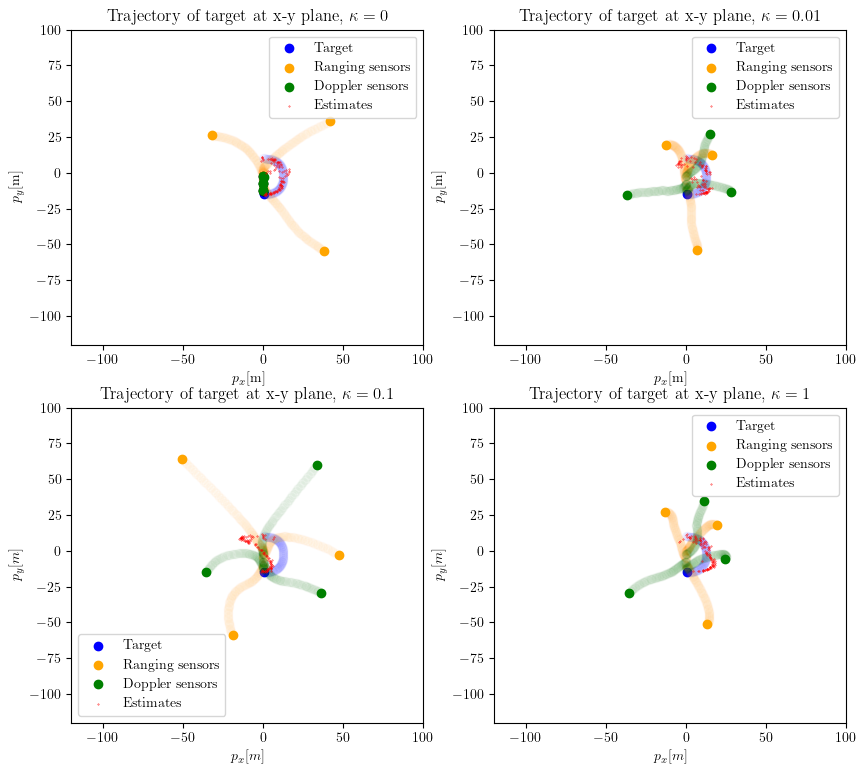

In [231]:
plt.figure(figsize=(10,9))
plt.subplot(2,2,1)
plt.scatter(target_k0[:,0,:], target_k0[:,1,:],c='blue',alpha=0.02)
plt.scatter(target_k0[-1,0,:], target_k0[-1,1,:],c='blue',alpha=1,label='Target')

plt.scatter(sensors_k0[:,0,:n_range_sensors], sensors_k0[:,1,:n_range_sensors], alpha=0.02,c='orange')
plt.scatter(sensors_k0[-1,0,:n_range_sensors], sensors_k0[-1,1,:n_range_sensors], alpha=1,c='orange',label='Ranging sensors')
plt.scatter(sensors_k0[:,0,n_range_sensors:], sensors_k0[:,1,n_range_sensors:], alpha=0.02,c='green')
plt.scatter(sensors_k0[-1,0,n_range_sensors:], sensors_k0[-1,1,n_range_sensors:], alpha=1,c='green',label='Doppler sensors')

plt.scatter(est_k0[:,0,:], est_k0[:,1,:], alpha=1,c='red',s=0.1,label='Estimates')
plt.title('Trajectory of target at x-y plane, $\kappa=0$')
plt.xlim(-120,100)
plt.ylim(-120,100)
plt.xlabel('$p_x$[m]')
plt.ylabel('$p_y$[m]')
plt.legend(loc='best')


plt.subplot(2,2,2)
plt.scatter(target_k001[:,0,:], target_k001[:,1,:],c='blue',alpha=0.02)
plt.scatter(target_k001[-1,0,:], target_k001[-1,1,:],c='blue',alpha=1,label='Target')

plt.scatter(sensors_k001[:,0,:n_range_sensors], sensors_k001[:,1,:n_range_sensors], alpha=0.02,c='orange')
plt.scatter(sensors_k001[-1,0,:n_range_sensors], sensors_k001[-1,1,:n_range_sensors], alpha=1,c='orange',label='Ranging sensors')
plt.scatter(sensors_k001[:,0,n_range_sensors:], sensors_k001[:,1,n_range_sensors:], alpha=0.02,c='green')
plt.scatter(sensors_k001[-1,0,n_range_sensors:], sensors_k001[-1,1,n_range_sensors:], alpha=1,c='green',label='Doppler sensors')

plt.scatter(est_k001[:,0,:], est_k001[:,1,:], alpha=1,c='red',s=0.1,label='Estimates')
plt.title('Trajectory of target at x-y plane, $\kappa=0.01$')
plt.xlim(-120,100)
plt.ylim(-120,100)
plt.xlabel('$p_x$[m]')
plt.ylabel('$p_y$[m]')
plt.legend(loc='best')

plt.subplot(2,2,3)
plt.scatter(target_k01[:,0,:], target_k01[:,1,:],c='blue',alpha=0.02)
plt.scatter(target_k01[-1,0,:], target_k01[-1,1,:],c='blue',alpha=1,label='Target')

plt.scatter(sensors_k01[:,0,:n_range_sensors], sensors_k01[:,1,:n_range_sensors], alpha=0.02,c='orange')
plt.scatter(sensors_k01[-1,0,:n_range_sensors], sensors_k01[-1,1,:n_range_sensors], alpha=1,c='orange',label='Ranging sensors')
plt.scatter(sensors_k01[:,0,n_range_sensors:], sensors_k01[:,1,n_range_sensors:], alpha=0.02,c='green')
plt.scatter(sensors_k01[-1,0,n_range_sensors:], sensors_k01[-1,1,n_range_sensors:], alpha=1,c='green',label='Doppler sensors')

plt.scatter(est_k01[:,0,:], est_k01[:,1,:], alpha=1,c='red',s=0.1,label='Estimates')
plt.title('Trajectory of target at x-y plane, $\kappa=0.1$')
plt.xlim(-120,100)
plt.ylim(-120,100)
plt.xlabel('$p_x[m]$')
plt.ylabel('$p_y[m]$')
plt.legend(loc='best')

plt.subplot(2,2,4)
plt.scatter(target_k1[:,0,:], target_k1[:,1,:],c='blue',alpha=0.02)
plt.scatter(target_k1[-1,0,:], target_k1[-1,1,:],c='blue',alpha=1,label='Target')

plt.scatter(sensors_k1[:,0,:n_range_sensors], sensors_k1[:,1,:n_range_sensors], alpha=0.02,c='orange')
plt.scatter(sensors_k1[-1,0,:n_range_sensors], sensors_k1[-1,1,:n_range_sensors], alpha=1,c='orange',label='Ranging sensors')
plt.scatter(sensors_k1[:,0,n_range_sensors:], sensors_k1[:,1,n_range_sensors:], alpha=0.02,c='green')
plt.scatter(sensors_k1[-1,0,n_range_sensors:], sensors_k1[-1,1,n_range_sensors:], alpha=1,c='green',label='Doppler sensors')

plt.scatter(est_k1[:,0,:], est_k1[:,1,:], alpha=1,c='red',s=0.1,label='Estimates')
plt.title('Trajectory of target at x-y plane, $\kappa=1$')
plt.xlim(-120,100)
plt.ylim(-120,100)
plt.xlabel('$p_x[m]$')
plt.ylabel('$p_y[m]$')
plt.legend(loc='best')

In [ ]:

range_u_s = [-0.02,0.02]
range_u_t = [-0.01,0.01]

n_range_sensors = 4
previous_est = array([[1 ,2 ,15 ,0, 0, 0],[3,2,0,0,0,0]]).T#
sensor_helper = RangeSensor3DTorchUtils()
sensor_simulator = RangingSensors3D(zeros((6,4)))
frames_9 = tracking_3D_smooth(K,3,lr_s,lr_t,w2,smooth_3D_trajectory_5,previous_est)

In [165]:
cost_9,sensors_9,target_9,est_9,crb_rmse_p_9 = extract_costs(frames_9)

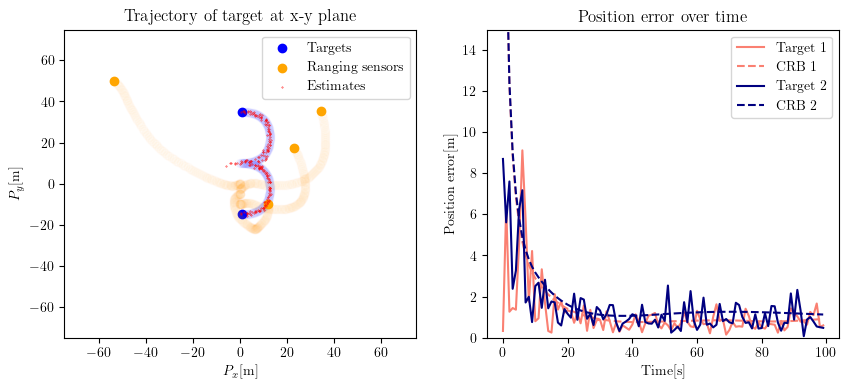

In [168]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(target_9[:,0,:], target_9[:,1,:],c='blue',alpha=0.02)
plt.scatter(target_9[-1,0,:], target_9[-1,1,:],c='blue',alpha=1,label='Targets')

plt.scatter(sensors_9[:,0,:], sensors_9[:,1,:], alpha=0.02,c='orange')
plt.scatter(sensors_9[-1,0,:], sensors_9[-1,1,:], alpha=1,c='orange',label='Ranging sensors')
plt.scatter(est_9[:,0,:], est_9[:,1,:], alpha=1,c='red',s=0.1,label='Estimates')
plt.title('Trajectory of target at x-y plane')
plt.xlim(-75,75)
plt.ylim(-75,75)
plt.xlabel('$P_x$[m]')
plt.ylabel('$P_y$[m]')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(np.array(cost_9)[:,0],c='salmon',label='Target 1')
plt.plot(crb_rmse_p_9[:,0],c='salmon',linestyle='dashed',label='CRB 1')
plt.plot(np.array(cost_9)[:,1],c='navy',label='Target 2')
plt.plot(crb_rmse_p_9[:,1],c='navy',linestyle='dashed',label='CRB 2')
plt.ylim(0,15)
plt.xlabel('Time[s]')
plt.ylabel('Position error[m]')
plt.title('Position error over time')
plt.legend(loc='best')
plt.savefig('two-targets-range.pdf')

In [ ]:

#n_doppler_sensors = 3
#sensor_helper = EnsembledSensor3DTorchUtils(n_range_sensors)
#sensor_simulator = EnsembledSensors3D(n_range_sensors,zeros((6,7)))


n_range_sensors = 4
previous_est = array([[1 ,2 ,15 ,0, 0, 0],[3,2,0,0,0,0]]).T#
sensor_helper = RangeSensor3DTorchUtils()
sensor_simulator = RangingSensors3D(zeros((6,4)))
frames_2 = tracking_3D_smooth(K,3,lr_s,lr_t,w2,smooth_3D_trajectory_5,previous_est)
cost_2,sensors_2,target_2,est_2,velo_2 = extract_costs(frames_2,True)

In [ ]:
n_range_sensors = 4
previous_est = array([[1 ,2 ,15 ,0, 0, 0],[3,2,0,0,0,0]]).T#
sensor_helper = RangeSensor3DTorchUtils()
sensor_simulator = RangingSensors3D(zeros((6,4)))
frames_3 = tracking_3D_smooth(K,3,lr_s,lr_t,w2,smooth_3D_trajectory_5,previous_est,ekf=True)
cost_3,sensors_3,target_3,est_3,velo_3 = extract_costs(frames_3,True)

In [ ]:
mc2 = []
mc3 = []
M = 20

for i in range(M):
    print('i=',str(i))
    try:
        n_range_sensors = 4
        previous_est = array([[1 ,2 ,15 ,0, 0, 0],[3,2,0,0,0,0]]).T#
        sensor_helper = RangeSensor3DTorchUtils()
        sensor_simulator = RangingSensors3D(zeros((6,4)))
        frames_2 = tracking_3D_smooth(K,3,lr_s,lr_t,w2,smooth_3D_trajectory_5,previous_est)
        cost_2,sensors_2,target_2,est_2 = extract_costs(frames_2)
        mc2.append(cost_2)
    except:
        print('?',str(i))
        
    try:   
        n_range_sensors = 4
        previous_est = array([[1 ,2 ,15 ,0, 0, 0],[3,2,0,0,0,0]]).T#
        sensor_helper = RangeSensor3DTorchUtils()
        sensor_simulator = RangingSensors3D(zeros((6,4)))
        frames_3 = tracking_3D_smooth(K,3,lr_s,lr_t,w2,smooth_3D_trajectory_5,previous_est,ekf=True)
        cost_3,sensors_3,target_3,est_3 = extract_costs(frames_3)
        mc3.append(cost_3)
    except:
        print('?',str(i))
    
        

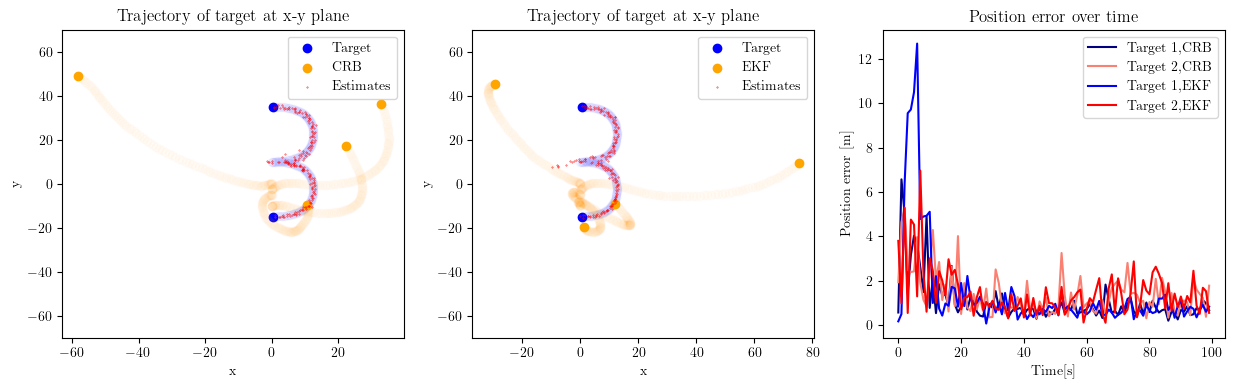

In [640]:
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.scatter(target_2[:,0,:], target_2[:,1,:],c='blue',alpha=0.02)
plt.scatter(target_2[-1,0,:], target_2[-1,1,:],c='blue',alpha=1,label='Target')

plt.scatter(sensors_2[:,0,:], sensors_2[:,1,:], alpha=0.02,c='orange')
plt.scatter(sensors_2[-1,0,:], sensors_2[-1,1,:], alpha=1,c='orange',label='CRB')
plt.scatter(est_2[:,0,:], est_2[:,1,:], alpha=1,c='red',s=0.1,label='Estimates')
plt.title('Trajectory of target at x-y plane')
#plt.xlim(-100,100)
plt.ylim(-70,70)
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='best')

plt.subplot(1,3,2)
plt.scatter(target_3[:,0,:], target_3[:,1,:],c='blue',alpha=0.02)
plt.scatter(target_3[-1,0,:], target_3[-1,1,:],c='blue',alpha=1,label='Target')

plt.scatter(sensors_3[:,0,:], sensors_3[:,1,:], alpha=0.02,c='orange')
plt.scatter(sensors_3[-1,0,:], sensors_3[-1,1,:], alpha=1,c='orange',label='EKF')
plt.scatter(est_3[:,0,:], est_3[:,1,:], alpha=1,c='red',s=0.1,label='Estimates')
plt.title('Trajectory of target at x-y plane')
#plt.xlim(-100,100)
plt.ylim(-70,70)
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='best')

plt.subplot(1,3,3)
plt.plot(array(cost_2)[:,0],c='navy',label='Target 1,CRB')
plt.plot(array(cost_2)[:,1],c='salmon',label='Target 2,CRB')
plt.plot(array(cost_3)[:,0],c='blue',label='Target 1,EKF')
plt.plot(array(cost_3)[:,1],c='red',label='Target 2,EKF')
plt.xlabel('Time[s]')
plt.ylabel('Position error [m]')
plt.title('Position error over time')
plt.legend()

In [ ]:


plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(target_2[:,0,:], target_2[:,1,:],c='blue',alpha=0.02)
plt.scatter(target_2[-1,0,:], target_2[-1,1,:],c='blue',alpha=1,label='Target')

#plt.scatter(sensors_2[:,0,:], sensors_2[:,1,:], alpha=0.02,c='orange')
#plt.scatter(sensors_2[-1,0,:], sensors_2[-1,1,:], alpha=1,c='orange',label='Ranging sensors')

plt.scatter(sensors_2[:,0,:n_range_sensors], sensors_2[:,1,:n_range_sensors], alpha=0.02,c='orange')
plt.scatter(sensors_2[-1,0,:n_range_sensors], sensors_2[-1,1,:n_range_sensors], alpha=1,c='orange',label='Ranging sensors')
plt.scatter(sensors_2[:,0,n_range_sensors:], sensors_2[:,1,n_range_sensors:], alpha=0.02,c='green')
plt.scatter(sensors_2[-1,0,n_range_sensors:], sensors_2[-1,1,n_range_sensors:], alpha=1,c='green',label='Doppler sensors')
plt.scatter(est_2[:,0,:], est_2[:,1,:], alpha=1,c='red',s=0.1,label='Estimates')
plt.title('Trajectory of target at x-y plane')
#plt.xlim(-100,100)
plt.ylim(-70,70)
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(array(cost_2)[:,0],c='navy',label='Target 1')
plt.plot(array(cost_2)[:,1],c='salmon',label='Target 2')
plt.xlabel('Time[s]')
plt.ylabel('Position error [m]')
plt.title('Position error over time')
plt.legend()

#plt.savefig('two-targets-mix.pdf', bbox_inches='tight')  
#plt.savefig('one-target-mix.pdf', bbox_inches='tight')  

#plt.subplot(1,3,3)
#for i in range(est_2.shape[2]):
#    plt.scatter(range(K),est_2[:,2,i],c='red',s=0.1,label='$\hat{p}_z$')
#    plt.scatter(range(K),target_2[:,2,i],c='blue',alpha=0.02)
#    plt.scatter([K],target_2[-1,2,i],c='blue',label='$p_z$')
#plt.xlabel('Time')
#plt.ylabel('z-axis')
#plt.ylim(0,15)
#plt.title('Tracking trajectory at z-axis')
#plt.legend()
#plt.show()

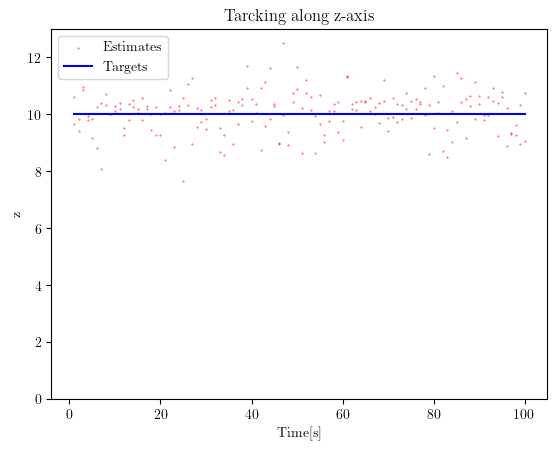

In [379]:
plt.scatter([i+1 for i in range(100)],est_2[:,2,0],s=0.1,c='red',label='Estimates')
plt.scatter([i+1 for i in range(100)],est_2[:,2,1],s=0.1,c='red')
plt.plot([i+1 for i in range(100)],target_2[:,2,0],c='blue',label='Targets')
plt.ylim(0,13)
plt.xlabel('Time[s]')
plt.ylabel('z')
plt.title('Tarcking along z-axis')
plt.legend()
plt.savefig('two-targets-mix-z.pdf', bbox_inches='tight')  
#plt.show()

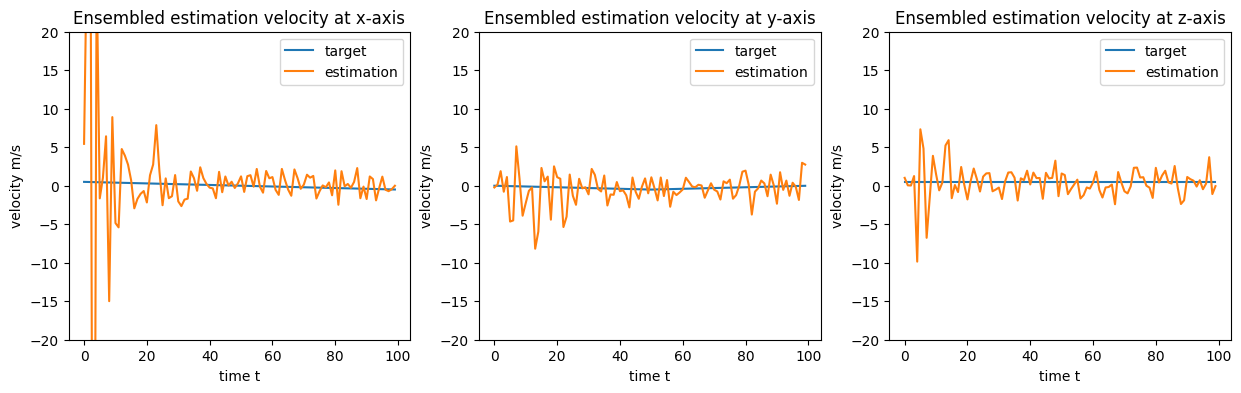

In [52]:
plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
plt.plot(target_2[:,3,:],label='target')
plt.plot(est_2[:,3,:],label='estimation')
plt.title('Ensembled estimation velocity at x-axis')
plt.xlabel('time t')
plt.ylabel('velocity m/s')
plt.ylim(-20,20)
plt.legend()

plt.subplot(1,3,2)
plt.plot(target_2[:,4,:],label='target')
plt.plot(est_2[:,4,:],label='estimation')
plt.title('Ensembled estimation velocity at y-axis')
plt.xlabel('time t')
plt.ylabel('velocity m/s')
plt.ylim(-20,20)
plt.legend()

plt.subplot(1,3,3)
plt.plot(target_2[:,5,:],label='target')
plt.plot(est_2[:,5,:],label='estimation')
plt.title('Ensembled estimation velocity at z-axis')
plt.xlabel('time t')
plt.ylabel('velocity m/s')
plt.ylim(-20,20)
plt.legend()
plt.show()

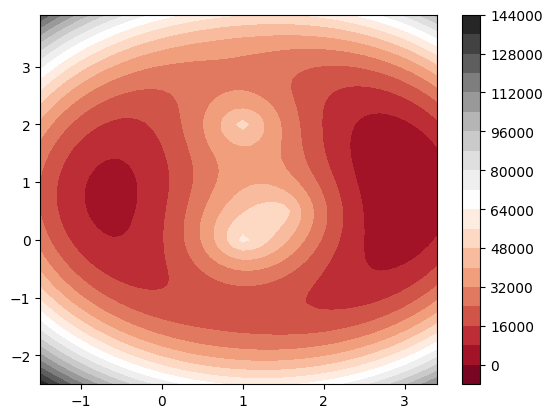

In [4026]:
sensors = np.array([[1,0],[1.5,0.5],[1,2]])
target = np.array([[3,1]])
s2 = 0.0001
alpha=0.05
mu,cov,d_mu,d_cov,inv_cov = stats_2d_range(sensors,target)
obs = simu_2d_range(mu,cov,size=3)

X,Y = np.mgrid[-1.5:3.5:0.1,-2.5:4:0.1]
N,M = X.shape
Z = np.zeros((N,M))
for i in range(N):
    for j in range(M):
        Z[i,j] = negloglikelihood((X[i,j],Y[i,j]),obs[0],lambda x:stats_2d_range(sensors,x))
        
        
plt.contourf(X, Y, Z, 20, cmap='RdGy')
plt.colorbar()
plt.show()